# Informe turnover Stark Industries

*En este jupyter se desarrollará la prueba técnica para obtar al cargo de DataScientist, mi nombre es Jorge Illanes Pareja y que tenga una agradable lectura.*

El objetivo principal de este análisis es ayudar a  a **mejorar sus contrataciones**.

En esta línea una pregunta que nos guiará en el análisis será: ¿Es posible identificar qué variables tienen mayor relevancia a la hora de predecir turnover según los datos entregados de los empleados? y ¿es posible crear un modelo que permita predecir si un nuevo empleado a contratar deje potencialmente su trabajo por algún motivo?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, pointbiserialr, spearmanr, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LearningCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, roc_auc_score


# EDA

Es crucial comprender con claridad el dataset para que cualquier análisis, modelo o conclusión generada sea de la mayor calidad posible, es por esto, que este apartado es el mas extenso del informe

In [3]:
# Cargamos el dataset, usamos encoding para evitar problemas con caracteres especiales.
df = pd.read_csv('turnover.csv', encoding='ISO-8859-1')
df.head(10)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
5,8.969199,1,f,42.0,manufacture,HR,empjs,yes,m,white,bus,6.2,6.2,4.1,5.6,6.7
6,8.969199,1,f,42.0,manufacture,HR,empjs,yes,m,white,bus,6.2,6.2,4.1,5.6,6.7
7,120.443532,1,f,28.0,Retail,HR,referal,no,m,white,bus,3.8,5.5,8.0,4.0,4.4
8,8.607803,1,f,29.0,Banks,HR,empjs,no,f,white,bus,8.6,6.9,2.6,4.0,7.5
9,4.435318,1,f,30.0,Consult,Marketing,youjs,yes,m,white,bus,5.4,5.5,3.3,7.9,8.3


Se nos proporciona un dataset con data variada e interesante:
- Datos personales
- Datos profesionales
- Origen de la contratación
- Jefaturas
- Formas de desplazamiento al lugar de trabajo
- Tipo de salario recibido
- Características de personalidad

Además posee la etiqueta para cada uno de los empleados:
- Rotación

Con esta información comenzamos con análisis rutinarios sobre la integridad


In [3]:
#Quitamos duplicados
print('Cantidad de registros duplicados:', df.duplicated().sum())
df.drop_duplicates(inplace=True)
#Información del dataset, tipo de dato y conteo de filas.
print(df.info())
print('*'*10)
#Conteo de nulos por columna
print('Nulos por categoría')
print(df.isnull().sum())

Cantidad de registros duplicados: 13
<class 'pandas.core.frame.DataFrame'>
Index: 1116 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1116 non-null   float64
 1   event         1116 non-null   int64  
 2   gender        1116 non-null   object 
 3   age           1116 non-null   float64
 4   industry      1116 non-null   object 
 5   profession    1116 non-null   object 
 6   traffic       1116 non-null   object 
 7   coach         1116 non-null   object 
 8   head_gender   1116 non-null   object 
 9   greywage      1116 non-null   object 
 10  way           1116 non-null   object 
 11  extraversion  1116 non-null   float64
 12  independ      1116 non-null   float64
 13  selfcontrol   1116 non-null   float64
 14  anxiety       1116 non-null   float64
 15  novator       1116 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 148.2+ KB
None
**********
Nulos p

Nuestras variables de tipo object son categóricas, las suponemos acotadas, por tanto, es recomendable transformarlas a tipo `category` para optimizar el consumo de memoria. 

Por otro lado, `age` pareciera ser una columna de valores enteros, analizaremos que sucede y tomaremos una decisión en relación a los valores.

El resto de datos pareciera estar en orden con su tipo, además, no tenemos presencia de Nulos.

Notar que la cantidad de filas duplicadas detectadas y eliminadas corresponde a 13. Consideramos que es poco probable que personas tengan todas las características mencionadas iguales. Asumimos que son filas repetidas.

In [4]:
#Transformamos las columnas correspondientes a category
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df[column] = df[column].astype('category')
print('Columnas Categoricas transformadas a category')

Columnas Categoricas transformadas a category


In [5]:
#Transformamos las columnas correspondientes a integer
integer_columns = ['age']
for column in integer_columns:
    df[column] = df[column].astype('int')
print('Columnas Enteras transformadas a int')

Columnas Enteras transformadas a int


Como sugerencia de parte del equipo técnico, renombramos las columnas descritas más abajo.


In [6]:
#Cambiamos el nombre de columnas
#Usamos el nombre de la columna en vez de su index por si cambian de orden para evitar errores.
new_columns_names = {'independ': 'agreeableness','selfcontrol': 'conscientiousness', 'anxiety': 'nueroticism','novator': 'openness'}
df.rename(columns=new_columns_names, inplace=True)

Como primer acercamiento a los datos realizamos un describe de la tabla que incluye estadísticos para detectar anormalidades en datos numéricos.

In [7]:
df.describe()

,stag,event,age,extraversion,agreeableness,conscientiousness,nueroticism,openness
count,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000,1116.000000
mean,36.701802,0.501792,31.021505,5.589606,5.474462,5.607527,5.666667,5.877330
std,34.173048,0.500221,6.973459,1.857401,1.702149,1.985720,1.711035,1.903534
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.720739,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.443532,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.622177,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


La tabla muestra consistencia en las variables de personalidad, age y stag.

Para la etiqueta `event` hay una media de 0.5, Si los valores son booleanos (representados con 0 o 1), estamos en presencia de una clase equilibrada.

Pareciera que la columna `stag` presenta una alta dispersión sobre el Cuartil 3 (25% superior de los datos), ya que el rango de valores es aproximadamente 128, consideración a tener presente cuando se analice con más detención.


### Label
#### Event

Analizamos explícitamente nuestra variable `event` para corroborar que tan balanceada o desbalanceada está

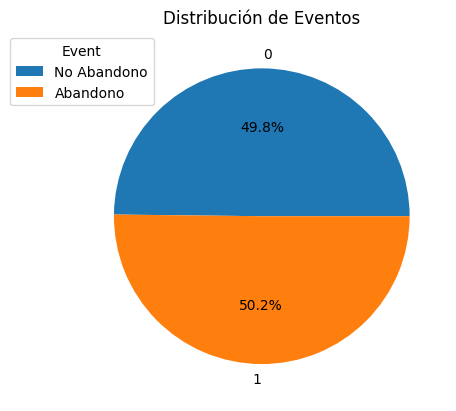

In [63]:
#Gráfico circular de distribución de eventos
event_counts = df['event'].value_counts().sort_values(ascending=True)
labels = ['No Abandono', 'Abandono']
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%')
plt.title('Distribución de Eventos')
plt.legend(labels, title = 'Event', loc = 'upper left', bbox_to_anchor = (-0.2, 0, 0.5, 1))
plt.show()

Efectivamente, nuestras clases están muy bien balanceadas. Esto será de ayuda a la hora de decidir las métricas a ocupar o los posibles modelos a implementar.

### Distribuciones de variables Categóricas por Label

Presentamos gráficos de las variables categóricas separadas por `event` para un primer análisis o indicio de si esta categoría puede estar relacionada o no con el abandono.

Cada gráfica muestra en color azul los empleados de esa categoría que no están clasificados en la etiqueta `event`, por tanto, no han rotado, en naranjo quienes sí.

Además, se muestra la proporción de cada una de las clases para cada categoría.

Columna: gender


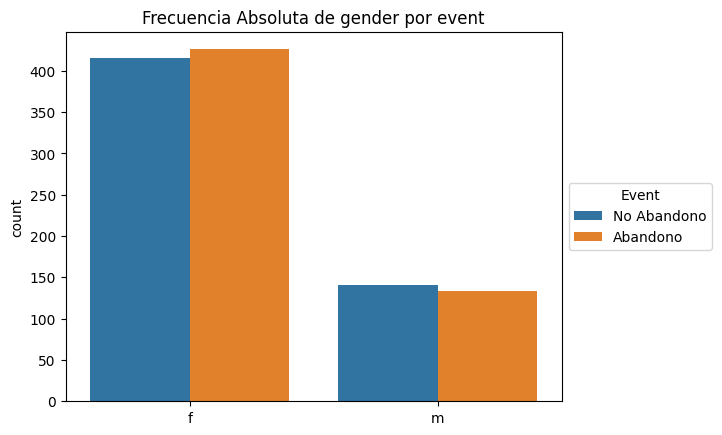

********************
Porcentajes de gender
gender
f    75.358423
m    24.641577
Name: proportion, dtype: float64
********************
Columna: industry


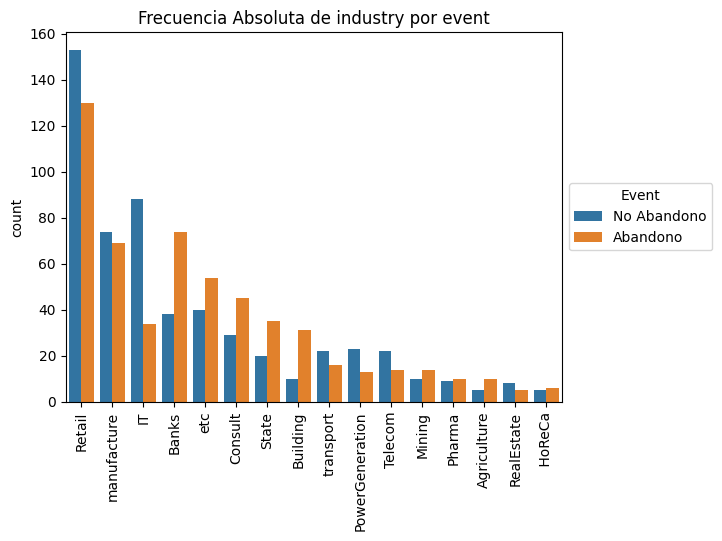

********************
Porcentajes de industry
industry
Retail             25.358423
manufacture        12.813620
IT                 10.931900
Banks              10.035842
etc                 8.422939
Consult             6.630824
State               4.928315
Building            3.673835
transport           3.405018
PowerGeneration     3.225806
Telecom             3.225806
Mining              2.150538
Pharma              1.702509
Agriculture         1.344086
RealEstate          1.164875
 HoReCa             0.985663
Name: proportion, dtype: float64
********************
Columna: profession


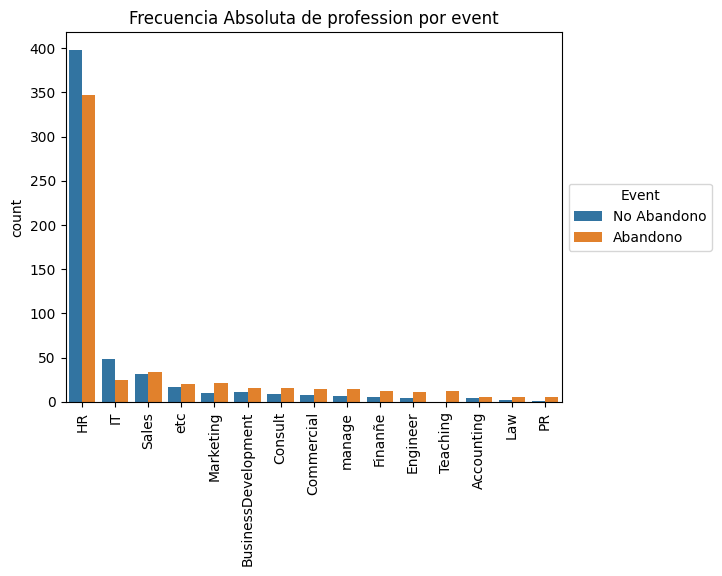

********************
Porcentajes de profession
profession
HR                     66.756272
IT                      6.630824
Sales                   5.824373
etc                     3.315412
Marketing               2.777778
BusinessDevelopment     2.419355
Consult                 2.240143
Commercial              2.060932
manage                  1.971326
Finanñe                 1.523297
Engineer                1.344086
Teaching                1.075269
Accounting              0.896057
Law                     0.627240
PR                      0.537634
Name: proportion, dtype: float64
********************
Columna: traffic


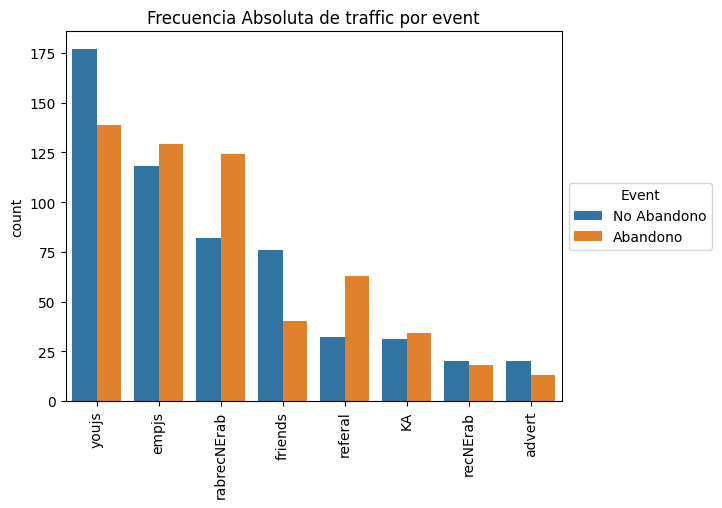

********************
Porcentajes de traffic
traffic
youjs          28.315412
empjs          22.132616
rabrecNErab    18.458781
friends        10.394265
referal         8.512545
KA              5.824373
recNErab        3.405018
advert          2.956989
Name: proportion, dtype: float64
********************
Columna: coach


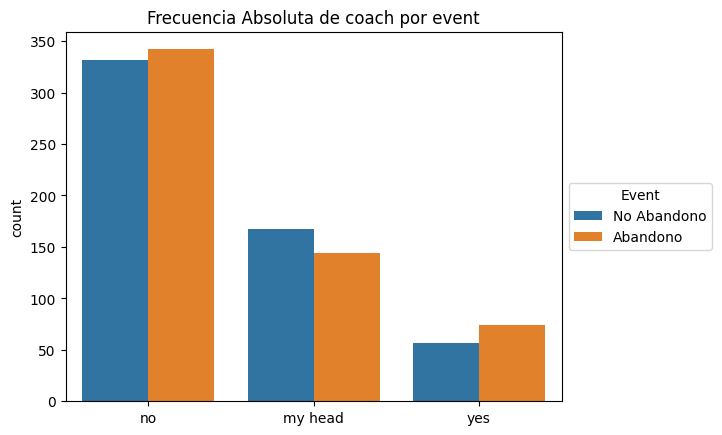

********************
Porcentajes de coach
coach
no         60.394265
my head    27.867384
yes        11.738351
Name: proportion, dtype: float64
********************
Columna: head_gender


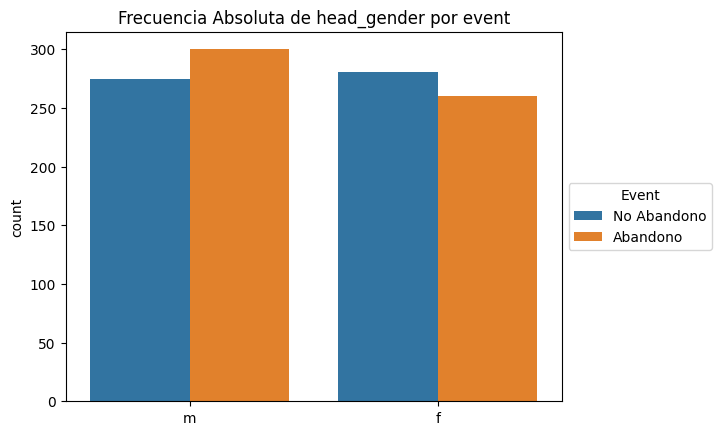

********************
Porcentajes de head_gender
head_gender
m    51.523297
f    48.476703
Name: proportion, dtype: float64
********************
Columna: greywage


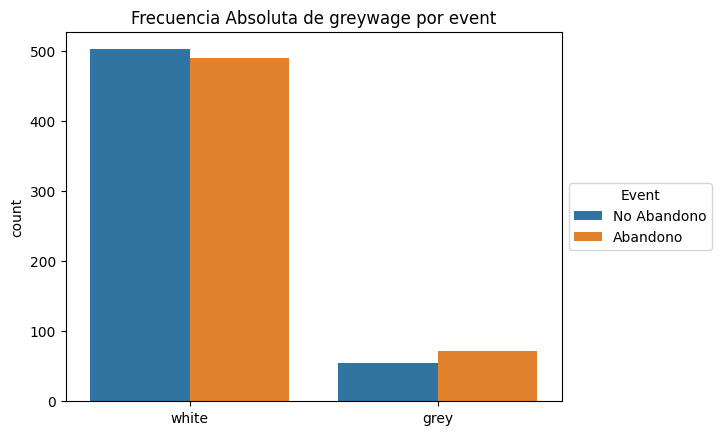

********************
Porcentajes de greywage
greywage
white    88.799283
grey     11.200717
Name: proportion, dtype: float64
********************
Columna: way


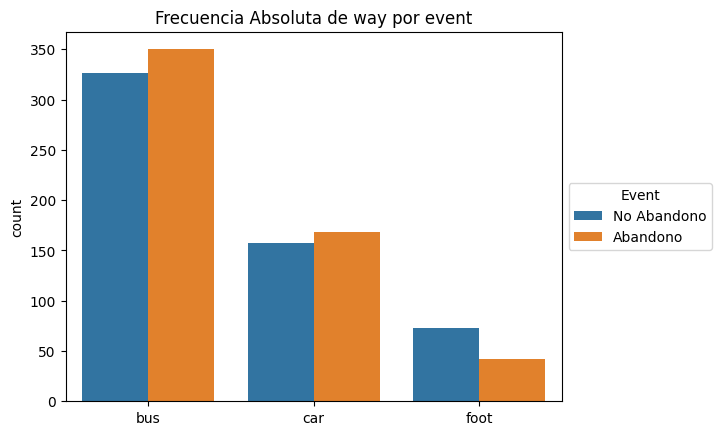

********************
Porcentajes de way
way
bus     60.573477
car     29.121864
foot    10.304659
Name: proportion, dtype: float64
********************


In [9]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns =  df.select_dtypes(exclude=[np.number]).columns
labels = ['No Abandono', 'Abandono']
for column in categorical_columns:
    print(f'Columna: {column}')
    sns.countplot(df, x=column, hue='event', stat='count', order=df[column].value_counts().index, )
    if df[column].nunique() > 6:
        plt.xticks(rotation=90)
    else:
        plt.xticks(rotation=0)
    plt.title(f'Frecuencia Absoluta de {column} por event')
    plt.legend(labels, title = 'Event', loc = 'center left', bbox_to_anchor = (1, 0, 0.5, 1))
    plt.xlabel('')
    plt.show()
    print('*'*20)
    print(f'Porcentajes de {column}')
    print(df[column].value_counts(normalize=True)*100)
    print('*'*20)

La primera exploración de las variables categóricas muestra lo siguiente:

1. A pesar de que la proporción de `gender f` es casi 3 veces la de `gender m` (75/25), el porcentaje de `head_gender` que corresponde a jefes es levemente superior en `m` que en `f`.
2. Un alto porcentaje (mayor 90%) recibe sueldos en blanco, que corresponden a salarios legales donde el empleado pagó los impuestos. El resto recibe salarios en gris, que tienen una parte de salario blanco y otra no (donde aun no se pagaron impuestos).
3. Un 60% de la muestra no tiene coach. Aproximadamente un 27.8% declara que su head es su coach y el resto sí tienen coach. Podríamos considerar que cercano a un 40% sí tiene coach contra un 60% que no.
4. Hay clases de la variable `traffic` que llaman la atención por su alta proporción de la muestra que rota, como rabrecNErab, que alcanza un 60%. `traffic` refiere de donde provienen quienes han empleados.
5. Pareciera existir una tendencia con quienes se desplazan caminando al trabajo, quienes rotan menos, esto al analizar la categoría `way`.

### Variables Categóricas

#### Traffic
Es una variable interesante a analizar. Puede estar directamente relacionada con el desempeño de los trabajadores.
Realizaremos algunas pruebas.

Agruparemos los datos por `traffic` y veremos algunas de agregaciones como el promedio, desviación estándar de `stag` y también `age` promedio.

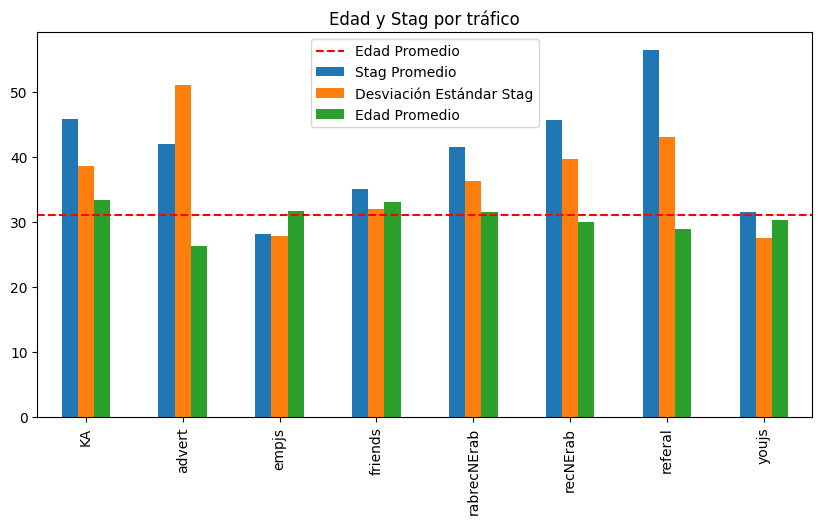

Coeficientes de variación de la variable stag por tráfico (Dispersión Relativa):


traffic
KA              84.032913
advert         121.364637
empjs           98.601234
friends         91.300148
rabrecNErab     87.582872
recNErab        86.777296
referal         76.387697
youjs           87.125381
Name: stag, dtype: float64

In [10]:
df.groupby('traffic', observed = False).aggregate({'stag': ['mean','std',], 'age': 'mean'}).plot(kind='bar', figsize=(10,5))
plt.title('Edad y Stag por tráfico')
plt.xlabel('')
plt.axhline(y=df['age'].mean(), color='r', linestyle='--', label='Promedio de Age')
plt.legend(['Edad Promedio', 'Stag Promedio', 'Desviación Estándar Stag', 'Edad Promedio'])
plt.show()

print(f'Coeficientes de variación de la variable stag por tráfico (Dispersión Relativa):')
df.groupby('traffic', observed = False)['stag'].std()/df.groupby('traffic', observed=False)['stag'].mean()*100

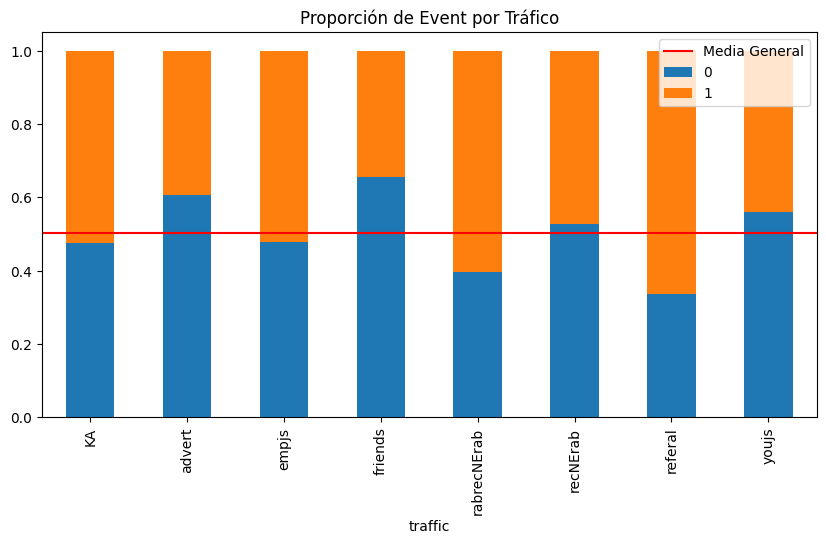

In [57]:

pd.crosstab(df['traffic'], df['event'], normalize='index').plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 5)
)
plt.axhline(y=df['event'].mean(), color='r', linestyle='-', label='Media General')
plt.legend()
plt.title('Proporción de Event por Tráfico')
plt.show()

Los empleados provenientes de `youjs y empjs` son quienes tienen, en promedio, menor `stag` (experiencia). Además las menores desviaciones estándar en comparación a las otras, lo que indica que estos valores son similares y por tanto, podemos decir que en general, youjs y empjs aportan con los empleados de peor experiencia. Por otro lado referal, KA y rabrecNErab aportan los empleados con mayor `stag` promedio. Sería interesante analizar en un futuro como se distribuye el stag para cada una de estas clases, pero para nuestro primer análisis no será necesario.

Si lo analizamos relativamente, las dispersiones de youjs y empjs no son la de mayor valor, en esta categoría empleados de advert son quienes presentan experiencias más variadas dentro del equipo que actualmente trabaja para la compañía.

Para el promedio, las clases no presentan mayor diferencia. El gráfico no está tomando en cuenta la frecuencia absoluta de cada clase, por si la línea pareciese estar sobre el promedio de las alturas de las barras verdes.

En relación al abandono, por lo visto en un gráfico anterior, tenemos que las clases `empjs , rabrecNErab y referal`son las que presentan mayor proporción de abandono que superan el 50%. Por lo menos, es interesante que referal y recNErab tengan asociado el mayor `stag` y por otro lado `empjs` es el de menor `stag`. Podríamos sostener que empleados con en los extremos de una distribución de experiencia, son quienes mayor tasa de abandono tienen.

#### Gender y Head_gender

De las gráficas no observamos diferencias tan marcadas en la mayoría de los casos, salvo para los head_gender masculinos. De aquí intentaremos comprobar si existe algún sesgo por sexo en la tasa de rotación de empleados

In [11]:
head_gender_gender = df.pivot_table(values = 'event', index='head_gender', columns='gender', aggfunc='sum', margins = True, margins_name = 'Total', observed=False)

#total_f = (df['gender'] == 'f').sum()
#total_m = (df['gender'] == 'm').sum()

#head_gender_gender['f'] = head_gender_gender['f'] / total_f * 100
#head_gender_gender['m'] = head_gender_gender['m'] / total_m * 100

head_gender_gender

gender,f,m,Total
head_gender,,,
f,224,36,260
m,202,98,300
Total,426,134,560


La tabla muestra un cruce entre `gender`y `head_gender` para los `event = 1`, empleados que rotan. Los valores muestran frecuencias absolutas donde la última fila y columna corresponde al total de su categoría vertical (`gender`) u horizontal (`head_gender`). En relación a los totales, no hay diferencias con la proporción global de `f` y `m` (mantienen aproximadamente 75/25). Similarmente ocurre en las filas `head_gender`.

Aplicaremos una prueba chi2 para ver si existen diferencias entre estos grupos.


In [12]:
# Create the contingency table
head_gender_gender = df.pivot_table(values = 'event', index='head_gender', columns='gender', aggfunc='sum', observed=False)
contingency_table = head_gender_gender.values

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(head_gender_gender)

# Print the results
print('p-value:', p_value)
print('Expected frequencies: \n', expected)

p-value: 3.27595913987111e-07
Expected frequencies: 
 [[197.78571429  62.21428571]
 [228.21428571  71.78571429]]


Considerando una significancia de $\alpha = 0.05$ concluimos que existe una relación entre estas variables que posiblemente no se deba al azar. Esto podría ser útil al enfocar el análisis en que `gender m` tiene un `head_gender m` corresponde aproximadamente a un 73% de la rotación de ese gender, en comparación a `gender f` que alcanza un 47%, siendo mucho más balanceado.

Esta combinación de variable podría estar relacionada con nuestra variable target.

#### gender

En relación a `gender` , suponemos que no hay una diferencia significativa entre ambos grupos (debido a las gráficas y lo explicao anteriormente), para eso corrobaremos con un test de proporciones de diferencia de medias proporcionales.

In [13]:
total_f = df['gender'].value_counts()['f']	
total_m = df['gender'].value_counts()['m']	

rotation_f = df[df['event'] == 1]['gender'].value_counts()['f']
rotation_m = df[df['event'] == 1]['gender'].value_counts()['m']

rotation_f_abs = rotation_f / total_f
rotation_m_abs = rotation_m / total_m

counts = np.array([rotation_f, rotation_m])
nobs = np.array([total_f, total_m])

stat, p_value = proportions_ztest(counts, nobs)

print(f'p-value: {p_value}')


p-value: 0.5790794648930964


El test de proporciones no arroja diferencias significativas entre `gender`f o m. Es decir, que no influye en la rotación de empleados.

#### head_gender
El mismo test aplicado a head_gender

In [14]:
total_f = df['head_gender'].value_counts()['f']	
total_m = df['head_gender'].value_counts()['m']	

rotation_f = df[df['event'] == 1]['head_gender'].value_counts()['f']
rotation_m = df[df['event'] == 1]['head_gender'].value_counts()['m']

rotation_f_abs = rotation_f / total_f
rotation_m_abs = rotation_m / total_m

counts = np.array([rotation_f, rotation_m])
nobs = np.array([total_f, total_m])

stat, p_value = proportions_ztest(counts, nobs)

print(f'p-value: {p_value}')

p-value: 0.16945015876186886


El test de proporciones no arroja diferencias significativas entre `head_gender`f o m. Es decir, que no influye en la rotación de empleados.

Esta es una demostración que variables por separado pueden no tener relación con una variable target, pero en conjunto si pueden aportar explicabilidad y predictibilidad.

#### Industry

Intuimos, por las gráficas del comienzo, que hay variaciones significativas en la tasa de rotación por industria.
Analizaremos si existen o no diferencia entre los distintos grupos, teniendo cuidado con la frecuencia absoluta de las clases con menor ocurrencia. Luego, en caso de existir, buscaremos cuales son las clases que presentan la mayor 

In [15]:
#Test chi2 para independencia de variables 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['industry'], df['event']))
print(f'p-value: {p}')

p-value: 1.8122296830108058e-08


El valor p es extremadamente pequeño, lo que da evidencia suficiente y muy fuerte para sostener que el tipo de industria está relacionado con la rotación.
Entonces el tipo de industria es un buen indicador para poder predecir si existirá mayor probabilidad de rotación. Procedemos a mostrar un gráfico stackeado para analizar las proporciones por industria.

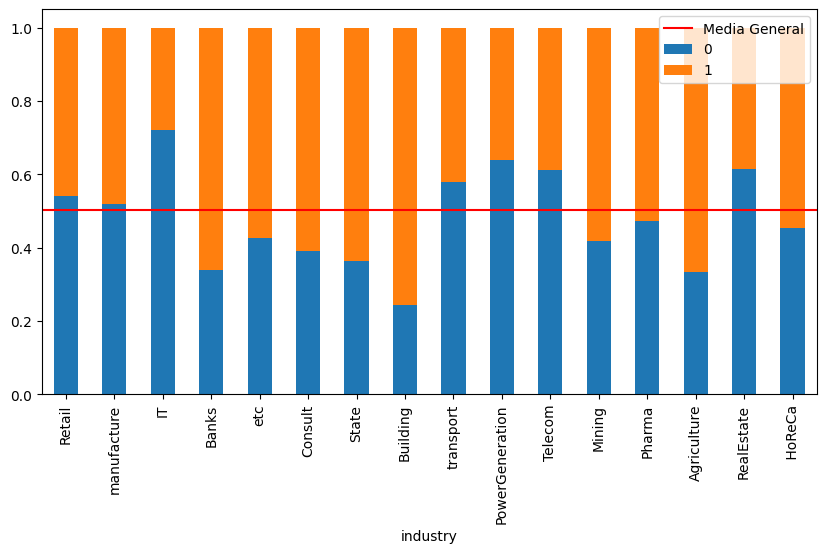

In [16]:
#Gráfico Stackeado de la proporción de eventos por industria
total_empleados = df['industry'].value_counts()
df['industry'] = pd.Categorical(df['industry'], categories=total_empleados.index, ordered=True)
pd.crosstab(df['industry'], df['event'], normalize='index').loc[total_empleados.index].plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 5)
)
plt.axhline(y=df['event'].mean(), color='r', linestyle='-', label='Media General')
plt.legend()
plt.show()

Observamos que industrias de TI, Power Generation, Telecom, RealEstate y transport tiene una menor rotación de empleados, siendo TI, la que logra una mejor retención.

Por el contrario, Building, Banks, Agriculture son las que tienen peor métricas en retención de empleados. Incluso Building está bajo el 30%, es decir, posee más de un 70% de rotación.

Industrias como Consult, State, Mining, Pharma, HoReCa y etc también presentan una mayor rotación que retención, pero en menor medida que las otras industrias, podemos suponer que está un poco más controlado.

Retail y manufacture tienen una tasa muy cercana al promedio general. Son sectores que podrían mejorar.

#### Profession

Repetiremos el análisis anterior para la columna Profession. Se espera menor relación debido a la profesión por lo visto en las gráficas del comienzo.

In [17]:
#Test chi2 para independencia de variables 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['profession'], df['event']))
print(f'p-value: {p}')

p-value: 2.8322544429984294e-05


Como el valor p es extremadamente pequeño, podemos sostener que existen diferencias significativas entre las distintas profesiones y su tasa de abandono.
Analicemos un poco más su gráfica para entender qué ocurre.

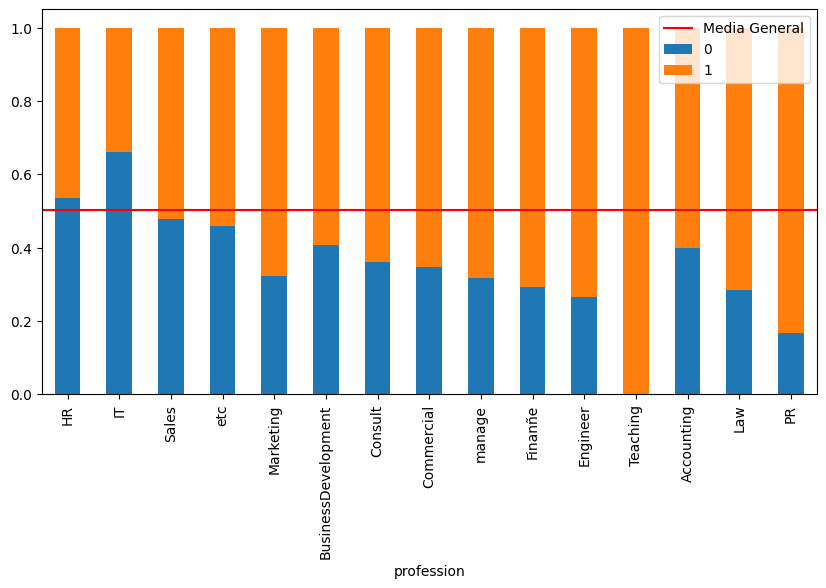

In [18]:
#Gráfico stackeado de la proporción de eventos por profesión
total_empleados = df['profession'].value_counts()
df['profession'] = pd.Categorical(df['profession'], categories=total_empleados.index, ordered=True)
pd.crosstab(df['profession'], df['event'], normalize='index').loc[total_empleados.index].plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 5)
)
plt.axhline(y=df['event'].mean(), color='r', linestyle='-', label='Media General')
plt.legend()
plt.show()


In [19]:
print('Total de empleados por categoría')
print(total_empleados)

Total de empleados por categoría
profession
HR                     745
IT                      74
Sales                   65
etc                     37
Marketing               31
BusinessDevelopment     27
Consult                 25
Commercial              23
manage                  22
Finanñe                 17
Engineer                15
Teaching                12
Accounting              10
Law                      7
PR                       6
Name: count, dtype: int64


Si bien, la gráfica muestra que la rotación de empleados es alta en la mayoría de las categorías de profession, debemos aclarar que desde la columna `Sales` hacia la derecha, el porcentaje empleados en la data es menor al 3% del total. El total por categoría puede apreciarse en la tabla anterior.

El área de mayor proporción, que es HR, esta tiene una tasa de retención superior a la media (representa a aproximadamente al 67% de la data) y esta tendencia de retención va disminuyendo a medida que disminuye el tamaño de la profession en el dataset. Asumiendo que los tamaños de los departamentos son similarmente proporcionales a lo recopilado en la data, puede existir una despreocupación por los departamentos más pequeños, que fomenta la alta rotación, en comparación a lo que ocurre en HR. Pueden ser muchos factores.

Lo que sí es claro, es que existe la tendencia a mayor rotación dependiendo del tamaño del departamento.


#### Coach

Si bien, en la gráfica inicial no se aprecian claras diferencias entre los grupos, creemos que podría estar relacionado con profession.

In [20]:
coach_profession = df.groupby(['coach', 'profession'], observed=False).agg({'event': 'sum'}).unstack()
coach_profession

event                                                          \
profession Accounting BusinessDevelopment Commercial Consult Engineer Finanñe   
coach                                                                           
my head             0                   7          2       6        3       3   
no                  6                   9         10       5        6       9   
yes                 0                   0          3       5        2       0   

                                                                
profession   HR  IT Law Marketing PR Sales Teaching etc manage  
coach                                                           
my head      86   7   2         5  0    14        2   5      2  
no          211  16   3        12  5    16        9  13     12  
yes          50   2   0         4  0     4        1   2      1

La tabla anterior muestra claramente que la mayor rotación absoluta se presenta cuando el empleado no tiene coach y es transversal para cada una de las profesiones. 
Analizaremos estos mismos valores de forma gráfica, pero porcentual con respecto a su departamento


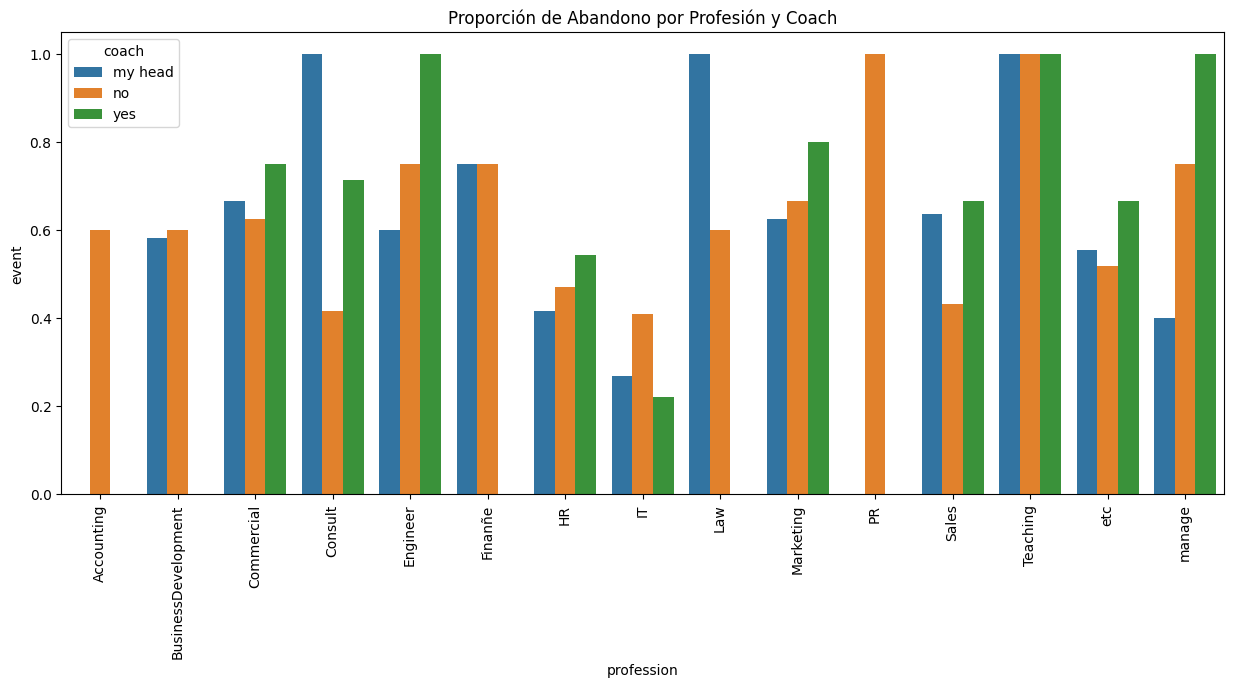

In [64]:
#Gráfico de proporción de abandono por profesión y coach
plt.figure(figsize=(15, 6))
sns.barplot(data=df, y='event', x='profession', hue='coach', errorbar= None)
plt.xticks(rotation=90)
plt.title('Proporción de Abandono por Profesión y Coach')
plt.show()

El gráfico descubre algo muy interesante. Hay alta rotación, contrario a lo esperado, cuando el empleado tiene un coach. En la mayoría de las categorías, salvo IT (Law y PR tienen departamentos muy pequeños), cuando el empleado tiene un coach, genera una mayor rotación. Incluso, la situación es igual de preocupante para las situaciones donde el coach es el jefe.

Considerando que solo un 30% de los empleados tiene un coach, podemos concluir que esto está relacionado con una mayor rotación. Podríamos sugerir que tener coach es una mala inversión, pero los casos de HR o IT descartan esta idea. Sería recomendable estudiar que está sucediendo en estos departamentos, donde el coach tiene una mayor efectividad al momento de reducir la rotación de empleados.

#### Greywage

El salario blanco o gris representa si es un salario legal con todos los descuentos de impuestos ya realizados o no (en el caso del gris), veremos si hay alguna relación utilizando un test.

In [22]:
#Test chi2 para independencia de variables 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['greywage'], df['event']))
print(f'p-value: {p}')

p-value: 0.13990544487532874


El test nos muestra que no hay diferencias significativas entre los grupos de salarios y su rotación. Es decir que el tipo de salario recibido no influyente en la rotación.

De todas maneras analizaremos si está en relación con profesion, debido a que profession es nuestra característica más relacionada con la rotación, hasta ahora.

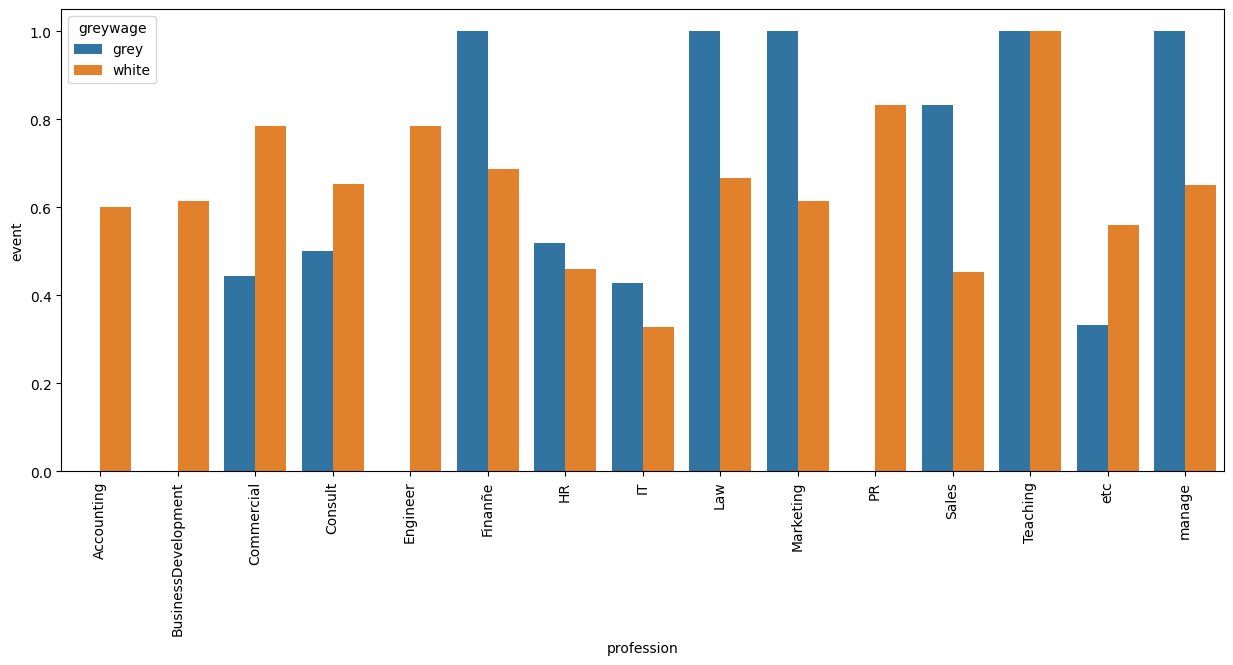

In [23]:
#Gráfico la proporción de eventos por tipo de salario	
plt.figure(figsize=(15, 6))
sns.barplot(data=df, y='event', x='profession', hue='greywage', errorbar= None)
plt.xticks(rotation=90)
plt.show()

#### Way

La última columna a analizar es `way` que corresponde a la forma en que llegan a lugar de trabajo.
Como es categórica, utilizaremos una prueba Chi2 para ver si existen diferencias entre los grupos, y en caso de que sí, poder analizarlas gráficamente o con algún otro test.

In [24]:
#Test chi2 para independencia de variables 
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['way'], df['event']))
print(f'p-value: {p}')

p-value: 0.008367976248189683


Como $p-value = 0.008 < 0.05 = \alpha$, hay diferencias entre los grupos, lo que puede indicar una dependencia entre la forma en que los empleados llegan a la empresa con la rotación. Veremos una gráfica y concluiremos el EDA.

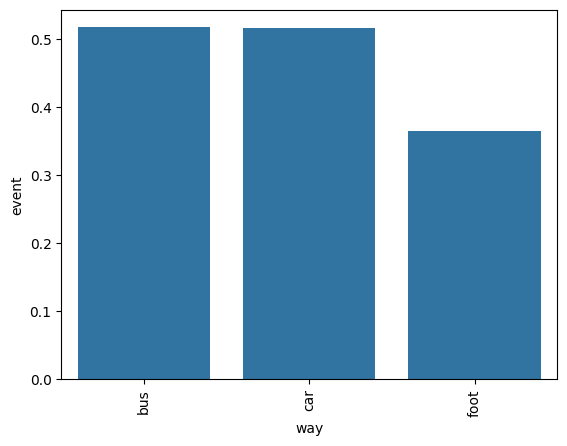

In [25]:
#Gráfico de la proporción de eventos por forma de viaje
sns.barplot(data=df, y='event', x='way', errorbar= None)
plt.xticks(rotation=90)
plt.show()

La gráfica muestra que quienes ocupan bus o car para llegar al trabajo tienen una mayor tasa de rotación. Suponemos que al llegar caminando las personas pueden vivir más cerca del lugar, por lo tanto, gastan menos tiempo en traslado, es más económico y/o es más relajado.

Observamos que no hay una relación clara entre el tipo de salario, las profesiones y la rotación.

### Distribución de variables Numéricas por Label

Distribución de feature `stag`

In [1]:
#Gráfico histograma para stag separado por evento
sns.histplot(data= df, x='stag', hue='event', bins=20, kde = True)

NameError: name 'sns' is not defined

En general, la distribución es similar, parecen tener medias similares pero varianzas distintas. Se alejan de ser distribuciones normales al estar muy sesgadas, para comprobar si hay alguna diferencia significativa aplicaremos un test estadístico para datos no normales.

In [27]:
#Test de MannWhitney-U para datos no normales
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df[df['event'] == 1]['stag'], df[df['event'] == 0]['stag'])
print(f'Estadístico Mann-Whitney: {stat}')
print(f'p-valor: {p}')
if p < 0.05:
    print('Hay una diferencia significativa entre los dos grupos (test no paramétrico)')
else:
    print('No hay una diferencia significativa entre los dos grupos (test no paramétrico)')

Estadístico Mann-Whitney: 148887.5
p-valor: 0.20708299486027615
No hay una diferencia significativa entre los dos grupos (test no paramétrico)


No hay diferencia significativa entre los grupos.

Procedemos a realizar una análisis similar con `age`

In [11]:
#Gráfico histograma para age separado por evento
sns.histplot(data= df, x='age', hue='event', bins=20, kde=True)

ValueError: Could not interpret value `hue` for `x`. An entry with this name does not appear in `data`.

Se puede apreciar una leve diferencia entre las distribuciones. Tenemos duda con la normalidad de los datos, aplicaremos test para decidir si lo son y luego aplicamos el test que corresponda para la diferencia de los grupos.

In [29]:
#Test shapiro para normalidad de los datos
stat, p = shapiro(df['age'])
print('Estadístico Shapiro:', stat)
print('p-valor:', p)

if p > 0.05:
    print('Los datos parecen seguir una distribución normal')
else:
    print('Los datos NO siguen una distribución normal')

Estadístico Shapiro: 0.9615156469033923
p-valor: 1.3962807141540928e-16
Los datos NO siguen una distribución normal


In [30]:
#Test de MannWhitney-U para datos no normales
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df[df['event'] == 1]['age'], df[df['event'] == 0]['age'])
print(f'Estadístico Mann-Whitney: {stat}')
print(f'p-valor: {p}')
if p < 0.05:
    print('Hay una diferencia significativa entre los dos grupos (test no paramétrico)')
else:
    print('No hay una diferencia significativa entre los dos grupos (test no paramétrico)')

Estadístico Mann-Whitney: 144416.0
p-valor: 0.03621147828662896
Hay una diferencia significativa entre los dos grupos (test no paramétrico)


Tenemos evidencia para sostener que hay una diferencia significativa entre los dos grupos, que son quienes rotan y que no, es decir, los grupos que rotan y no tienen medias distintas con una significancia del 5%. 

La variable `event` al ser binaria, puede esconder relaciones con otras variables que sean más difíciles de detectar, como relaciones no lineales. Este es un primer indicio de que esta categoría puede ser relevante a la hora del análisis. También la contrastaremos con otras técnicas de análisis o con modelos de Machine Learning para acercanos a una respuesta robusta, pero en primera instancia, es una variable a tener en consideración.

#### Dato Freak

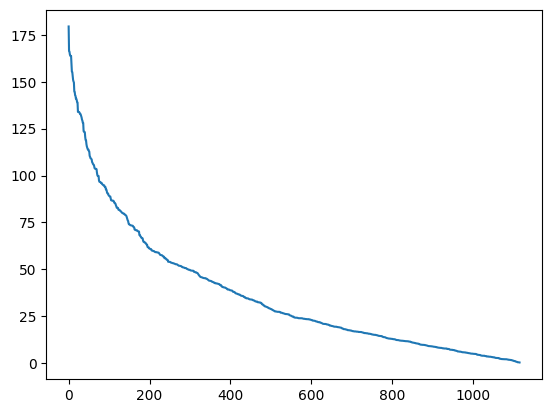

In [31]:
#Gráfica de la distribución de los datos ordenada de mayor a menor
ordered = df['stag'].sort_values(ascending=False)
plt.plot(ordered.values)

Dato Freak: La experiencia se distribuye aproximadamente logarítmica cuando ordenamos los datos de mayor a menor.

#### Correlaciones

Aplicaremos correlaciones de Spearman y Punto-Biseral. Debido a que nuestro target es una variable dicotómica, en un principio son mejores decisiones que una correlación de Pearson tradicional. Spearman por un lado es más robusta al poder detectar de mejor manera relaciones no lineales, aunque tampoco es el ideal, y por otro lado, punto -biserial es una modificación de pearson para trabajar con variables dicotómicas de mejor manera.

Esto ayudaría a la interpretabilidad de un futuro modelo, pero debemos tener en cuenta que pueden existir otras relaciones que este estadístico no esté detectando, principlamente por ser 1 a 1 entre features.

In [32]:
#Correlacion de Spearman y Point-Biserialr
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns_list = list(numeric_columns)
numeric_columns_list.remove('event')
for column in numeric_columns_list:
    spearmanr_correlation, spearmanr_p_value = spearmanr(df['event'], df[column])
    pb_correlation, pb_p_value = pointbiserialr(df['event'], df[column])
    print(column)
    print(f'Correlación de Spearman para {column}: {spearmanr_correlation}')
    print(f'Correlacion de Point-Biserial para {column}: {pb_correlation}')
    if spearmanr_p_value < 0.05 or pb_p_value < 0.05:
        print(f'Spearman p-valor: {spearmanr_p_value} , Point-Biserial p-valor: {pb_p_value}')
        print('Existe una correlación significativa en al menos uno de las correlaciones')
    else:
        print('No hay una correlación significativa')
    print('*'*20)

stag
Correlación de Spearman para stag: -0.03778553277727659
Correlacion de Point-Biserial para stag: -0.04781679872056199
No hay una correlación significativa
********************
age
Correlación de Spearman para age: -0.06272945215682448
Correlacion de Point-Biserial para age: -0.05374655598160079
Spearman p-valor: 0.03614502515491193 , Point-Biserial p-valor: 0.07268968794030525
Existe una correlación significativa en al menos uno de las correlaciones
********************
extraversion
Correlación de Spearman para extraversion: 0.016747382997809424
Correlacion de Point-Biserial para extraversion: 0.017588340244494828
No hay una correlación significativa
********************
agreeableness
Correlación de Spearman para agreeableness: 0.03526344341666662
Correlacion de Point-Biserial para agreeableness: 0.04603178243660129
No hay una correlación significativa
********************
conscientiousness
Correlación de Spearman para conscientiousness: -0.03776457471528081
Correlacion de Point-B

Solo se detectan dos relaciones importantes, pero bajas en fuerza, como lo son `age` y el rasgo de personalidad `nueroticism`. Mas adelante mostraremos una matriz de correlación con las variables ya escaladas y preprocesadas.

### Variables Cuantitativas

A continuación mostramos gráficas sobre la distribución de los datos en general, para observar de mejor manera estas débiles relaciones detectadas.

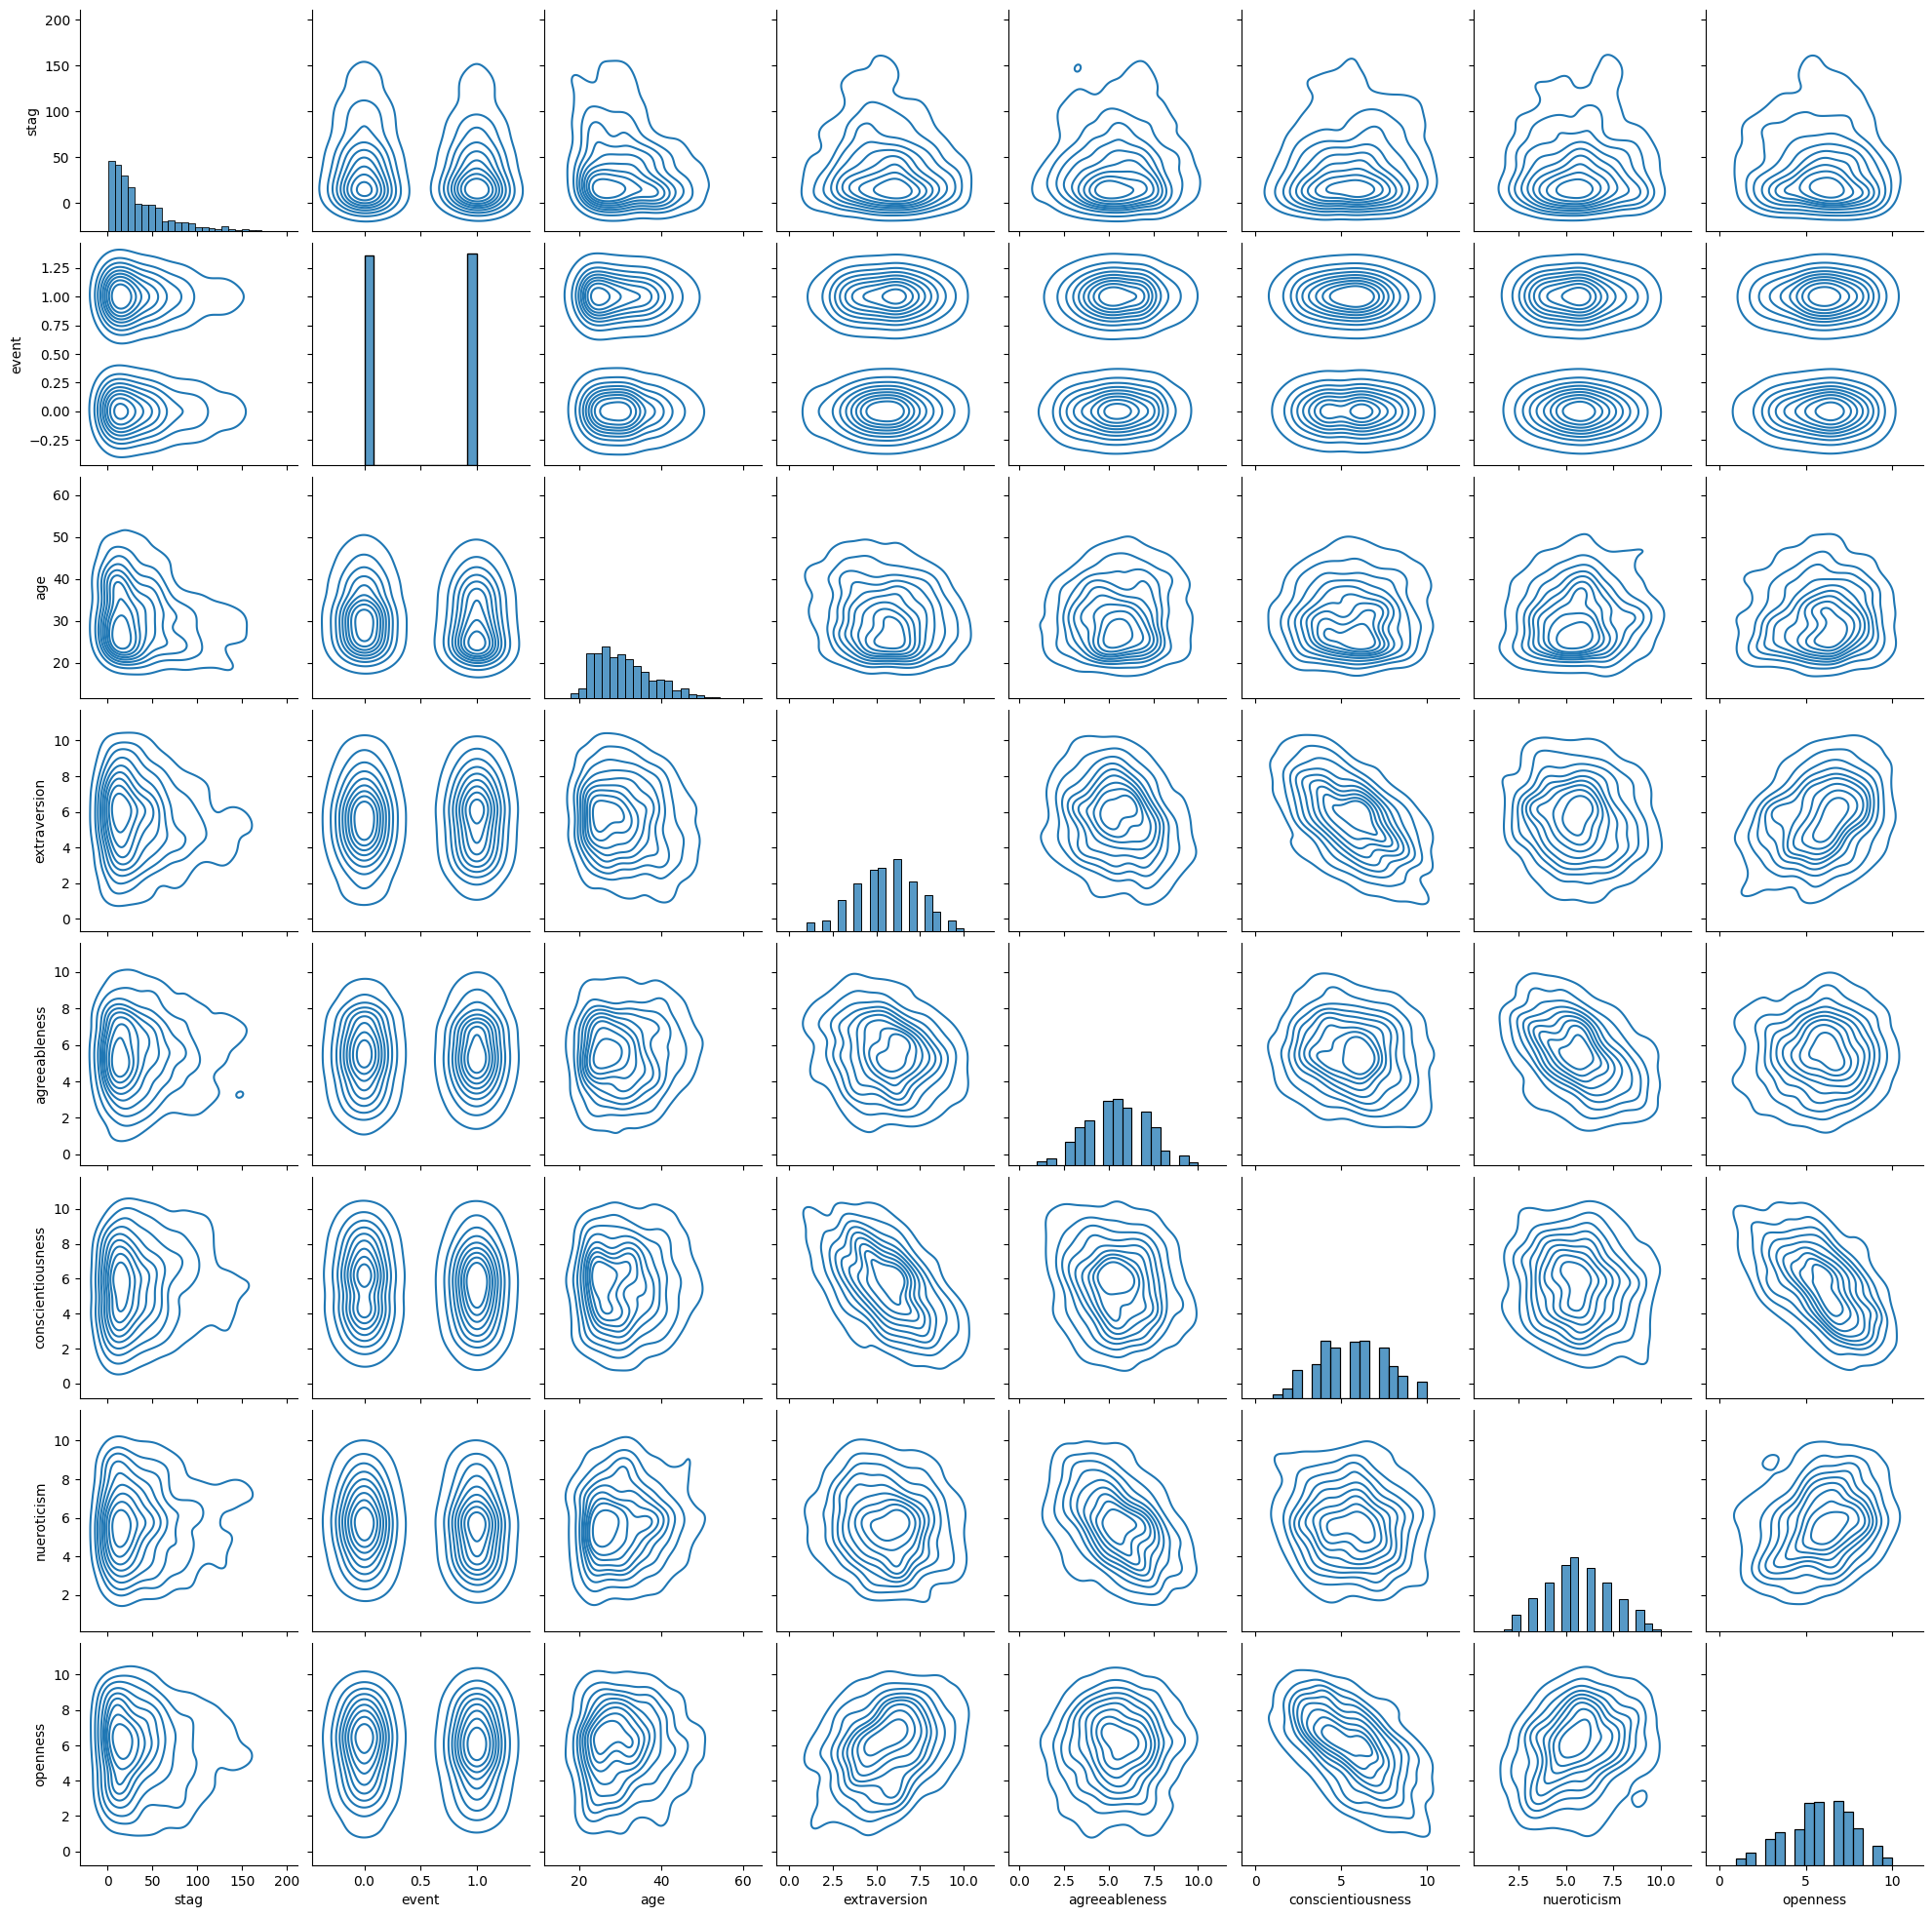

In [33]:
#numeric_columns = new_columns_names.values()
#numeric_columns = list(numeric_columns)
#numeric_columns.insert(0, 'event')
#numeric_columns.insert(1,'stag')
#numeric_columns.insert(2, 'age')
#numeric_columns.append('extraversion')
#numeric_colums = df.select_dtypes(include=[np.number]).columns

sns.pairplot(df[numeric_columns], kind='kde', diag_kind='hist')

Nuestras variables numéricas relacionadas a razgos de personalidad parecen estar normalmente distribuidas. También notamos que hay pares de variables que presentan correlación negativa. Analizaremos estas situaciones mediante el análisis de correlaciones de Pearson.

<Axes: >

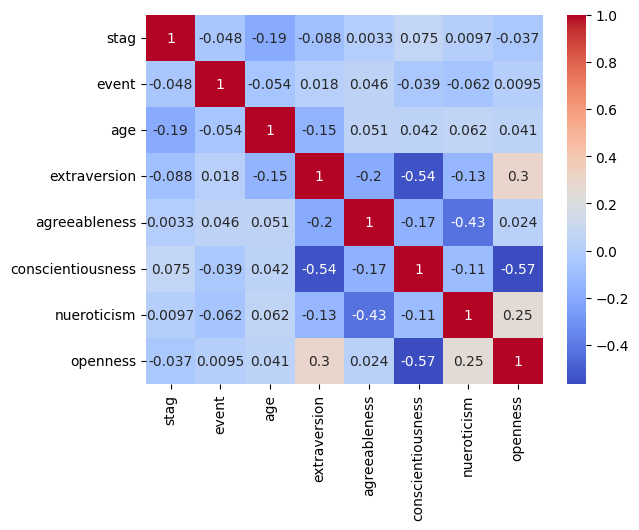

In [34]:
df[numeric_columns].corr(method='spearman')
sns.heatmap(df[numeric_columns].corr(), annot=True , cmap='coolwarm')

La correlaciones de `event` son débiles con todas las otras variables numéricas. Y según nuestros cálculos anteriores solo significativas en `age` y `nueroticism`. Esto indica que las correlaciones lineales son casi inexistentes entre la variable targe y las otras, sin embargo aun pueden quedar relaciones que estos estadísticos no detectan.

En el caso de otras variables relacionadas entre si, tenemos el caso de `extraversion` y `conscientiousness`, `agreeableness` con `nueroticism` y `conscientiousness` con `openess`, cuyas fuerzas son de fuerza media y de riección negativa. Por ejemplo, una persona con mayor extraversión tenderá a tener menor conscientiousness, pero no hay implicancias de causalidad. 

Estos datos nos sirven para comprender de mejor manera el dataset y aplicarlo en la interpretación de los modelos.

Si tuvieramos que seleccionar variables en este momento, sería complejo, porque solo hay dos que tienen un peso considerable con `event`,por este motivo, no sería una práctica recomnedada y dejaremos que otras técnicas nos ayuden en esa tarea.

Finalmente realizaremos un análisis de los grupos de event 0 o 1 son similares o no en relación a las características de personalidad. Creemos que no lo serían por lo presentado en las correlaciones anteriores, salvo en nueroticism

In [35]:
from scipy.stats import ttest_ind
#numeric_columns_list.remove('stag')
#numeric_columns_list.remove('age')
group_0 = df[df['event'] == 0][numeric_columns_list]
group_1 = df[df['event'] == 1][numeric_columns_list]


for col in group_0.columns:
    stat, p_value = ttest_ind(group_0[col], group_1[col])
    print(f'Característica: {col}')
    print(f'Estadístico t: {stat}, Valor p: {p_value}')
    if p_value < 0.05:
        print('Hay una diferencia significativa entre los dos grupos')
    print('*'*20)

Característica: stag
Estadístico t: 1.5977916845857465, Valor p: 0.1103729330828332
********************
Característica: age
Estadístico t: 1.7964759812895894, Valor p: 0.07268968794030532
********************
Característica: extraversion
Estadístico t: -0.5871304961480291, Valor p: 0.5572350383693705
********************
Característica: agreeableness
Estadístico t: -1.5380164984773363, Valor p: 0.12432855256610917
********************
Característica: conscientiousness
Estadístico t: 1.3123900445128436, Valor p: 0.18965889495572882
********************
Característica: nueroticism
Estadístico t: 2.068601035047343, Valor p: 0.038813837784660354
Hay una diferencia significativa entre los dos grupos
********************
Característica: openness
Estadístico t: -0.31738461699436443, Valor p: 0.7510112533900847
********************


La hipótesis del test establece que los grupos no tienen diferencia significativa. Como son distribuciones aproximadamente normales (se puede apreciar gráficamente) podemos aplicar un t-test. Para este caso, es aplica el test de 2 colas para probar diferencia entre las columnas de los grupos que tuvieron rotación y los que no.

La única columna con diferencia entre los grupos es `nueroticism` con $p-value = 0.033 < 0.5 = \alpha $. Si bien es menor, es relativamente cercano al umbral de significancia. 
En los demás grupos no tenemos evidencia significativa para rechazar la idea de que los grupos son distintos, por lo tanto, nos quedamos con la hipótesis de las medias son iguales.

De todas maneras, `nueroticism` tiene una fuerza de correlación con `event` muy baja. Graficaremos esta subdivisión clarificar cuál es la diferencia.


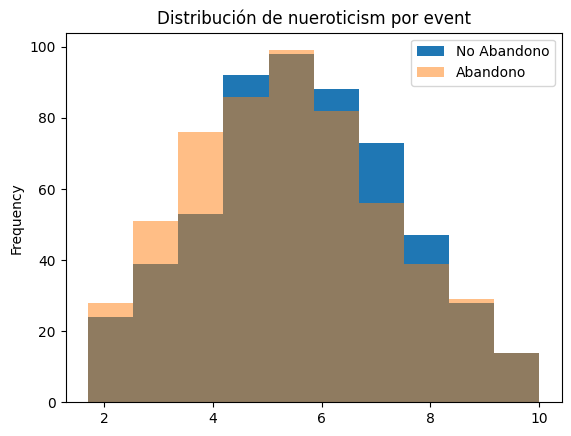

In [52]:
group_0 = df[df['event'] == 0]['nueroticism'].plot(kind='hist')
group_1 = df[df['event'] == 1]['nueroticism'].plot(kind='hist', alpha=0.5)
plt.title('Distribución de nueroticism por event')
plt.legend(['No Abandono', 'Abandono'])


Hay una pequeña diferencia en el sesgo de la distribución, sesgada a la izquierda en los empleados etiquetados en rotación y a la derecha en el otro grupo, aunque es un sesgo muy pequeño. De hecho, las medias tienen una diferencia de aproximadamente 0.2 unidades. Sin embargo, es una variable que podríamos obviar del análisis, y en caso de requerir alguna extra, podríamos llegar a considerarla.

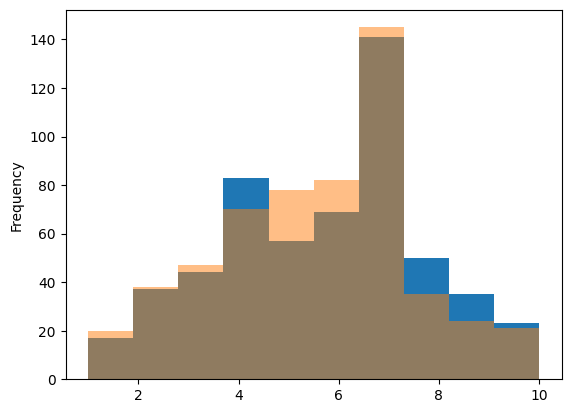

In [37]:
group_0 = df[df['event'] == 0]['conscientiousness'].plot(kind='hist')
group_1 = df[df['event'] == 1]['conscientiousness'].plot(kind='hist', alpha=0.5)

Podemos ver la comparación con `conscientiousness`, donde la distribución en general es similar, las diferencias entre ambas son menores.

Entendiendo el concepto de `nueroticism`, relacionado con actitudes y pensamientos negativos de una persona puede estar un poco más relacionado con una rotación, pues la persona podría mostrarse vulnerable ante alguna situación o estímulo. *[Fuente](https://mejorconsalud.as.com/neuroticismo-sintomas-tratamiento/)*

# Conclusiones EDA

Nos referiremos a los hallazgos relacionados con el objetivo principal, es decir, con la rotación o la columna `event`

- La Industria donde se desarrolla el empleado está ligada con una mayor o menor tasa de rotación. De esta manera `event` y `industry` tienen relación.
- Profession tiene una relación con la rotación. Según el departamento donde se desempeña el empleado obtenemos mayores tasas de rotación, e incluso, está muy ligado al tamaño del departamento. Esto implica que `profession`y `event` están relacionadas.
- Que un empleado tenga coach, está relacionado con una mayor rotación. Por lo tanto, las columnas `coach` y `event` deben tener alguna relación.
- Hay una relación entre las columnas `way` y `event`. El medio de transporte que utilizan para llegar al lugar de trabajo podría estar influenciando a la rotación.
- Por último `neuroticism` tiene una correlación muy débil y negativa con `event`, pero es significativa, entonces puede existir un pequeño porcentaje de rotación que esté explicada por esta variable.

El resto de variable parece no estar relacionadas directamente con la rotación, sin embargo, pueden existir relaciones de dos o más variables que pueden ser explicativas y predictoras para el modelo, como lo analizamos en el caso de `head_gender` y `gender`. Esa tarea quedará en manos de los algoritmos que utilizaremos en el preprocesamiento y modelado.



# Preprocesamiento
Ya habiendo analizado el dataset, procederemos realizar una pareparación de los datos para aplicar algunos modelos de clasificación de aprendizaje supervisado.
Encodeamos nuestras variables categóricas para poder utilizar modelos de Machine Learning

In [38]:
categorical_columns = df.select_dtypes(include=['category']).columns
encoder = OneHotEncoder(sparse_output = False, drop='if_binary')
encoded = encoder.fit_transform(df[categorical_columns])

encoded_categories = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(categorical_columns))
df.reset_index(drop=True, inplace=True)
encoded_df = pd.concat([df.drop(categorical_columns, axis=1), encoded_categories], axis=1)

#encoder = LabelEncoder()
#for column in categorical_columns:
    #df[column] = encoder.fit_transform(df[column])



In [39]:
encoded_df.head()

,stag,event,age,extraversion,agreeableness,conscientiousness,nueroticism,openness,gender_m,industry_ HoReCa,...,traffic_referal,traffic_youjs,coach_my head,coach_no,coach_yes,head_gender_m,greywage_white,way_bus,way_car,way_foot
0,7.030801,1,35,6.2,4.1,5.7,7.1,8.3,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,22.965092,1,33,6.2,4.1,5.7,7.1,8.3,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,15.934292,1,35,6.2,6.2,2.6,4.8,8.3,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,15.934292,1,35,5.4,7.6,4.9,2.5,6.7,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,8.410678,1,32,3.0,4.1,8.0,7.1,3.7,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [40]:
X = encoded_df.drop('event', axis=1)
y = encoded_df['event']

#X = df.drop('event', axis=1)
#y = df['event']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
#Función para curva ROC
def roc_auc_plot(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC: {auc}')

    # Graficar curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()
    
#Función para evaluar el modelo
def evaluate_model(y_pred, y_test):
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', yticklabels=['Real No Abandono', 'Real Abandono'], xticklabels=['Pred No Abandono', 'Pred Abandono'])
    plt.title('Matriz de Confusión')
    plt.show()

#### Logistic Regression

La regresión es un modelo muy simple de comprender, interpretable y económico computacionalmente. Sin embargo si las relaciones están muy lejos de ser lineales puede tener un bajo desempeño.

En este escanario, difícilmente una regresión logística podría entregar un mejor modelo que alguno de los otros algoritmos, pero igualmente debemos probarlo en caso de que nuestra suposición esté muy equivocada.


Mejores hiperparámetros: {'C': 10, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Puntaje del modelo: 0.5946930693069307
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        56
           1       0.69      0.66      0.67        56

    accuracy                           0.68       112
   macro avg       0.68      0.68      0.68       112
weighted avg       0.68      0.68      0.68       112



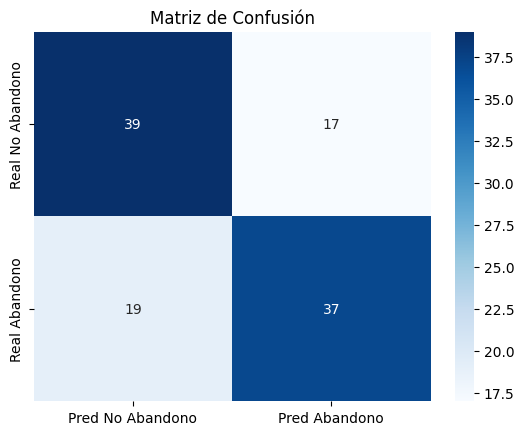

AUC: 0.7184311224489796


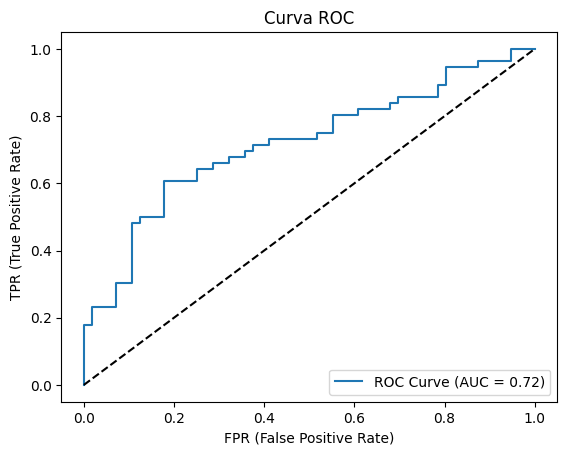

In [42]:
#Preparemos la búsqueda de hiperparámetros
params = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'sag'],
    'C': [0.01,0.1,  1, 10, 100,],
    'max_iter': [100, 500, 1000, 10000],
    'fit_intercept': [True, False],
}
logistic = LogisticRegression()
grid_search = GridSearchCV(logistic, param_grid=params, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Mejores hiperparámetros:', best_params)
print('Puntaje del modelo:', best_score)

logistic_model = LogisticRegression(**best_params)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

evaluate_model(y_pred, y_test)
roc_auc_plot(logistic_model, X_test, y_test)


La presición del modelo es baja y con el test de prueba también lo es. El AUC de ROC es más cercano a un valor que se refiere a un modelo con poca capacidad de predicción que a uno utilizable. Nuestra suposición inicial fue corroborada al realizar los distintos entrenamientos con variación de hiperparámetros.

En este caso, este modelo no sería el recomendado.

### Desicion Tree Classifier

Este modelo de clasificación es una excelente opción si la interpretabilidad del modelo es lo suficiente importante como para no preferir una mejor optimización en la predicción.

A través de un diagrama podemos observar claramente de que manera está funcionando el modelo.

El algoritmo es capaz encontrar relaciones en variables que de otra manera sería complicado hacerlo, incluso estadística o gráficamente

Mejores hiperparámetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'random_state': 42, 'splitter': 'random'}
Puntaje del modelo: 0.6246237623762376
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        56
           1       0.69      0.68      0.68        56

    accuracy                           0.69       112
   macro avg       0.69      0.69      0.69       112
weighted avg       0.69      0.69      0.69       112



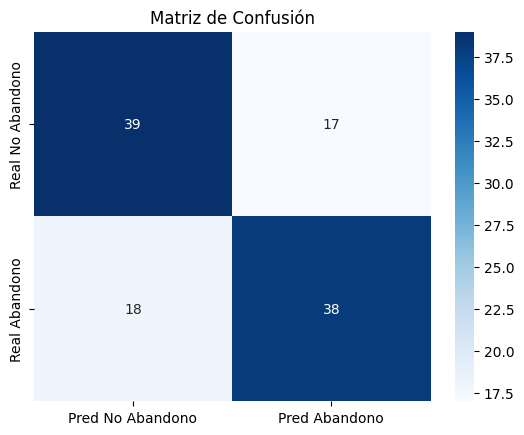

AUC: 0.7197066326530612


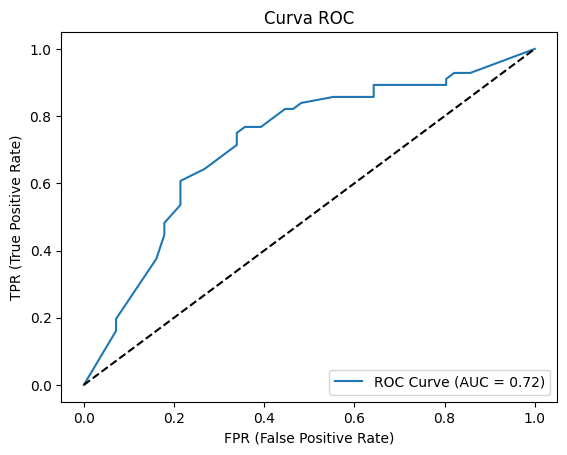

In [43]:
#Preparamos la búsqueda de hiperparámetros
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [4, 5, 6, 7, 8],
    'max_features': ['sqrt', 'log2'], 
    'class_weight': ['balanced', None],
    'random_state': [42]
}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, param_grid=params, scoring='accuracy', cv=10, n_jobs = -1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Mejores hiperparámetros:', best_params)
print('Puntaje del modelo:', best_score)

tree_model = DecisionTreeClassifier(**best_params)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

evaluate_model(y_pred, y_test)
roc_auc_plot(tree_model, X_test, y_test)


Las métricas arrojan un modelo que es un poco mejor que una clasificación aleatoria en un entrenamiento, pero al hacer la prueba con los datos de entrenamiento, tiene un leve rendimiento mejor. LA Curva ROC muestra que existen umbrales donde alcanzar casi un 80% de aciertos con menos de un 40% de falsos positivos, que es mucho mejor en comparación a la regresión logística pero sigue siendo un rendimiento sub óptimo. 

Si el modelo tuviese que ser explicable, una primera aproximación podría ser la utilización del árbol.

#### KNN

K-Nearest Neighbors es un modelo sencillo de comprender y explicar. Busca mediante distintas técnicas como clasificar mediante los vectores más cercanos que tenga, según distintas métricas.

Mejores hiperparámetros: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Puntaje del modelo: 0.6455247524752475
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.61      0.68        56
           1       0.68      0.82      0.74        56

    accuracy                           0.71       112
   macro avg       0.72      0.71      0.71       112
weighted avg       0.72      0.71      0.71       112



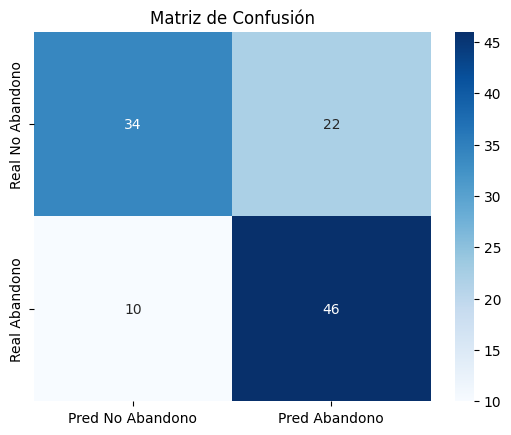

AUC: 0.7802933673469388


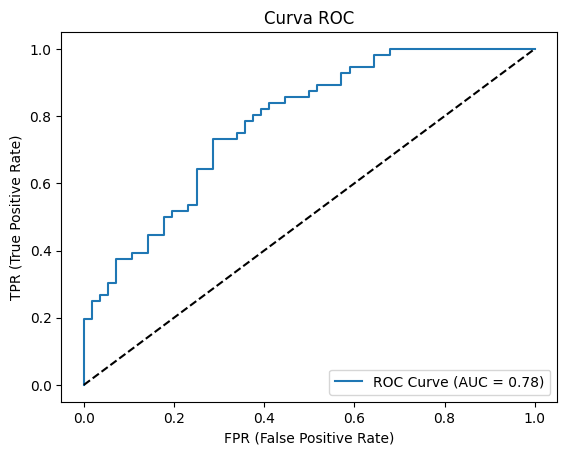

In [44]:
#Preparamos la búsqueda de hiperparámetros
params = {
    'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10,15, 20, 25, 30, 40, 50],
    'p': [1, 2, 3],
    'metric': ['euclidean', 'manhattan']
}
pca_transformer = PCA(n_components=10).fit(X_train)
X_train_pca = pca_transformer.transform(X_train)
X_test_pca = pca_transformer.transform(X_test)


knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
 
print('Mejores hiperparámetros:', best_params)
print('Puntaje del modelo:', best_score)    

#Entrenar el modelo con los mejores hiperparámetros
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(X_train_pca, y_train)
y_pred = knn_model.predict(X_test_pca)

evaluate_model(y_pred, y_test)
roc_auc_plot(knn_model, X_test_pca, y_test)


KNN es un modelo que presenta un rendimiento medianamente aceptable, pero como veremos más adelante, está sobreajustado segpun el learning curve. Por temas de tiempo no logramos dar con los hiperparámetros para no tener un sobreajuste.

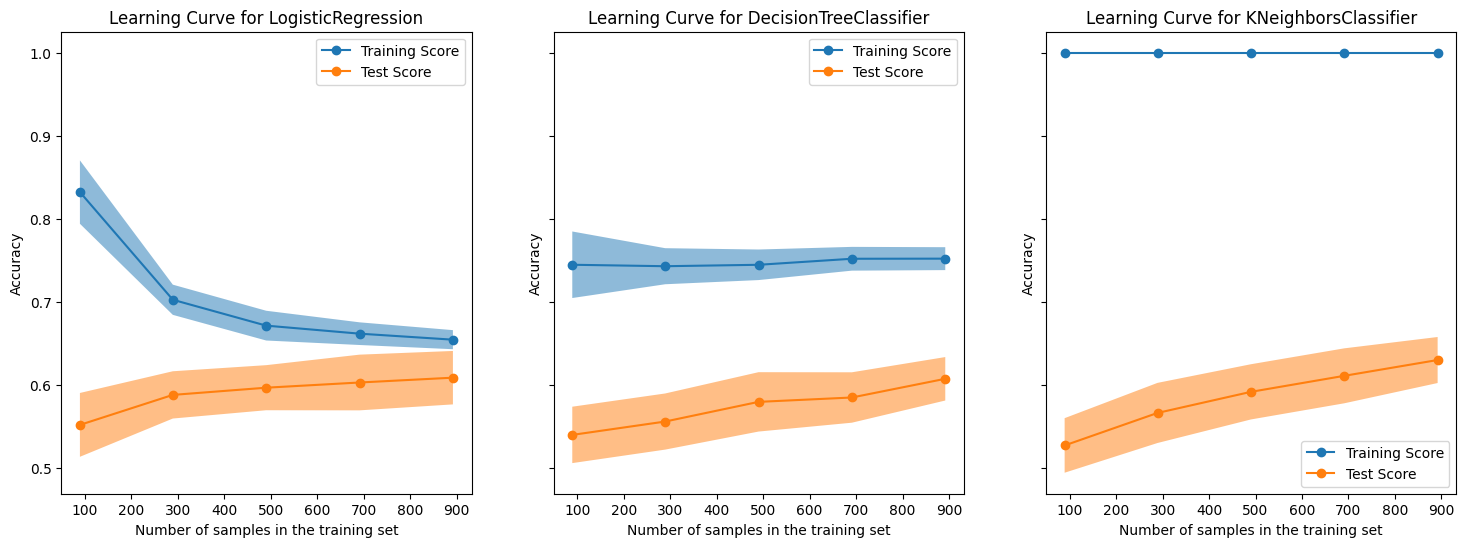

In [45]:
#Gráfico de curvas de aprendizaje
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

common_params = {
    'X': X,
    'y': y,
    'train_sizes': np.linspace(0.1, 1.0, 5),
    'cv': ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    'score_type': 'both',
    'n_jobs': 4,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
    'score_name': 'Accuracy',
}

for ax_idx, estimator in enumerate([logistic_model, tree_model, knn_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ['Training Score', 'Test Score'])
    ax[ax_idx].set_title(f'Learning Curve for {estimator.__class__.__name__}')

### Random Forest Classifier

Un modelo de Random Forest es un modelo de ensamble, compuesto por muchos modelos de árboles de decisión como los que se emplearon anteriormente. Al igual que los árboles anteriores, cada uno de estos árboles es fácilmente interpretable, pero este conjunto de árboles hace que el modelo global sea más difícil de interpretar.

En general, un Random Forest es un modelo robusto que obtiene buenos resultados y mejora lo que puede hacer un único árbol de decisión. En este sentido, si el objetivo es la predicción por sobre la interpretabilidad del modelo, esta sería una muy buena elección.

En caso de necesitar saber que atributos son los que el modelo está considerando más influyentes, podemos obtener la importancia como un atributo del mismo modelo ya entrenado, así podríamos ayudarnos a entender de mejor manera que variables están influyendo en esta clasificación.

En caso de necesitar una mayor explicabilidad se puede optar por un modelo mas interpretable u ocupar una explicación unificada a través del método SHAP, cuya inclusión no se encuentra en este trabajo.

Mejores hiperparámetros: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 48, 'random_state': 42}
Puntaje del modelo: 0.6623861386138614
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        56
           1       0.73      0.79      0.76        56

    accuracy                           0.75       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.75      0.75      0.75       112



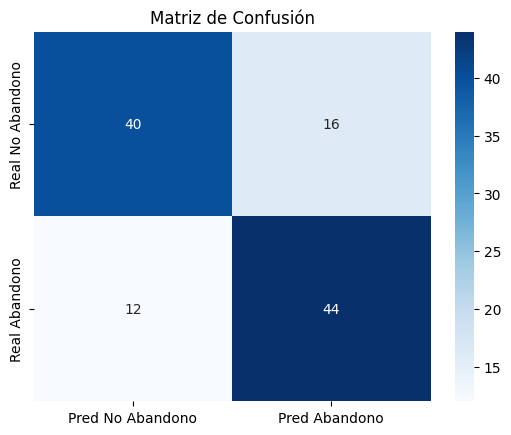

AUC: 0.8380102040816326


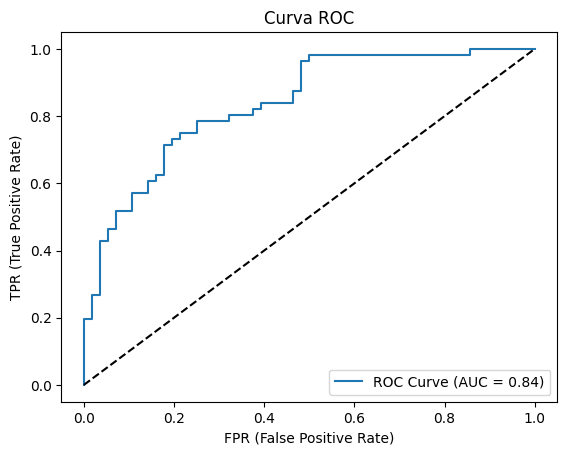

In [46]:
#Preparamos la búsqueda de hiperparámetros
params = {'n_estimators': [24 ,32,36,48 ,64, 96],
          'criterion': ['gini', 'entropy'],
          'class_weight': ['balanced', {0:1, 1:2}],
          'random_state' : [42],
          'max_depth': [5,7,10],
          'min_samples_leaf': [10, 3, 4],
          'min_samples_split': [4,5],
          'max_features': ['sqrt','log2'], }
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


print('Mejores hiperparámetros:', best_params)
print('Puntaje del modelo:', best_score)    

#Entrenar el modelo con los mejores hiperparámetros
rfc_model = RandomForestClassifier(**best_params)
rfc_model.fit(X_train, y_train)
y_pred = rfc_model.predict(X_test)

evaluate_model(y_pred, y_test)
roc_auc_plot(rfc_model, X_test, y_test)

### SVM Classifier

Support Vector Machines es un algoritmo que es efectivo cuando hay muchas dimensiones, sin embargo perdemos interpretabilidad al requerir de una abstracción tan grande en relación a la formación y separación de los vectores mediante hiperplanoes en hiperespacios.

Como principal desventaja tenemos un alto requerimiento de memoria RAM, pero para este tamaño de dataset no esun problema a considerar.

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Mejores hiperparámetros: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Puntaje del modelo: 0.7075757575757576
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        56
           1       0.72      0.70      0.71        56

    accuracy                           0.71       112
   macro avg       0.71      0.71      0.71       112
weighted avg       0.71      0.71      0.71       112



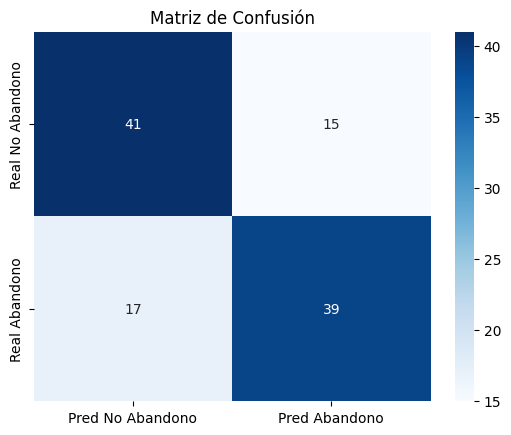

AUC: 0.7767857142857142


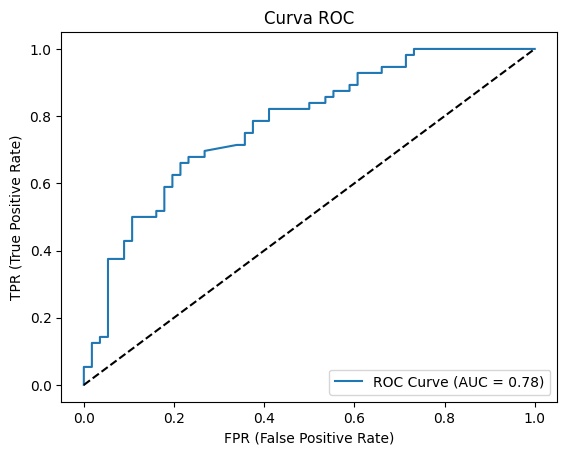

In [47]:
#Preparar la búsqueda de hiperparámetros
params = {'C': [0.1, 1, 10, 100, 1000],
          'gamma': [1,0.1, 0.01, 0.01, 0.0001],
          'kernel': ['rbf'],
          'random_state': [42],
          'probability': [True],
          }

svm_c = SVC()
grid_search = GridSearchCV(svm_c, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1, refit = True, verbose = 3)
grid_search.fit(X_test, y_test)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
 
print('Mejores hiperparámetros:', best_params)
print('Puntaje del modelo:', best_score)    

#Entrenar el modelo con los mejores hiperparámetros
svm_model = SVC(**best_params)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

evaluate_model(y_pred, y_test)
roc_auc_plot(svm_model, X_test, y_test)



El modelo presenta un déficit grave en el rendimiento cuando optimizaba por accuracy donde teníamos  un recall de 0.18 en la clase 1, lo que indica que de los ejemplos que realmente pertenecen a la clase 1, está detectando solo el 18%, lo cual es preocupante. 

Por este motivo cambiamos el score a roc_auc.

Puede existir algún error en la configuración de hiperparámetros, pero se ha probado muchas veces, este modelo quizá no es el más adecuado para este problema.

*Si bien sería recomendable probar y ajustar más modelos, por temás de tiempo seguiremos adelante*

Ahora, entre todos los modelos, el que presenta mejor rendimiento en general es el Random Forest Clasiffier, para eso, lo analizaremos un poco más y veremos si es posible optimizar alguna métrica interés cambiando el umbral. Para eso veremos el ROC-AUC

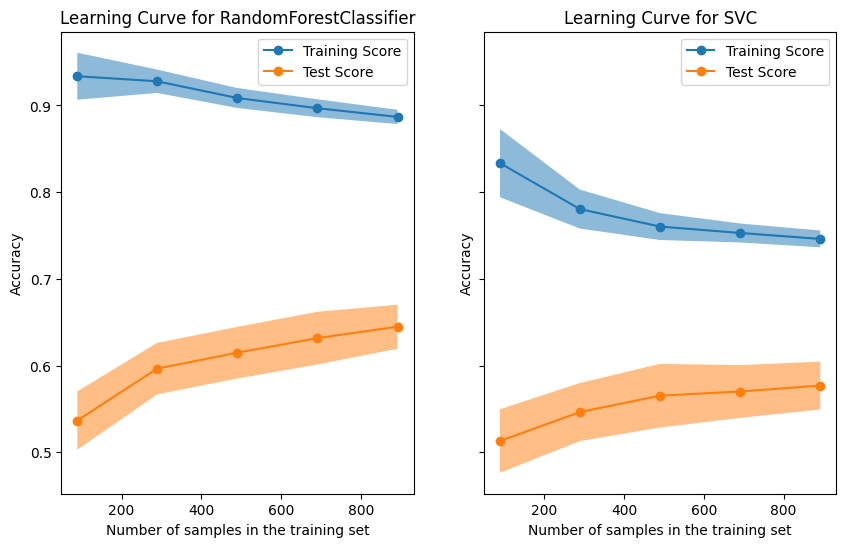

In [48]:
#Gráfico de curvas de aprendizaje
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    'X': X,
    'y': y,
    'train_sizes': np.linspace(0.1, 1.0, 5),
    'cv': ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    'score_type': 'both',
    'n_jobs': 4,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
    'score_name': 'Accuracy',
}

for ax_idx, estimator in enumerate([rfc_model, svm_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ['Training Score', 'Test Score'])
    ax[ax_idx].set_title(f'Learning Curve for {estimator.__class__.__name__}')

## ROC-AUC


Random Forest es el modelo que tiene las mejores métricas en general, destacando con su AUC de 0,84 que se considera bueno, porque tiene una capacidad de discriminación entre las clases positivas y negativas. Pero sus demás métricas no son tan alentadoras. Ahora, si considermaos su curva aprendizaje, es probable que el método aun no haya alcanzado todo su potencial y pudiese seguir mejorando al agregar más datos o hacer ajustes adicionales de hiperparámetros.
Se observa una buena tasa de verdaderos positivos al inicio con baja tasa de negativos.

En caso de querer maximizar alguna métrica, por ejemplo el TPR - FRP (Índice de Youden), podríamos buscarlo de la siguiente manera

In [49]:
# Encuentra el umbral que maximiza la diferencia entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
y_pred_proba = rfc_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.524277427697871


Y luego corroborar como hubiese quedado nuestra matriz de confusión y las métricas para ese modelo al cambiar el umbral de la probabilidad para considerar a las clases respectivas.

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        56
           1       0.80      0.71      0.75        56

    accuracy                           0.77       112
   macro avg       0.77      0.77      0.77       112
weighted avg       0.77      0.77      0.77       112



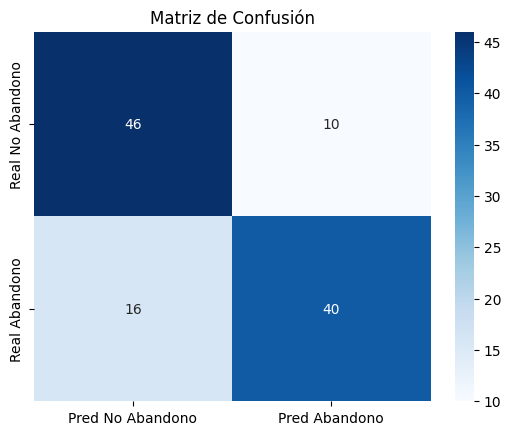

In [50]:
# Ajustar las predicciones con el umbral óptimo
y_pred_proba = rfc_model.predict_proba(X_test)[:, 1]

umbral = 0.524
y_pred_adjusted = (y_pred_proba >= umbral).astype(int)

evaluate_model(y_pred_adjusted, y_test)

Logramos un accuracy de 0.77, y un recall de 0.71 para la clase 1 sin un modelo sobreajustado como se puede observar en las learning curves, en caso de requerir mejorar otra médica, podemos ir mejorando el umbral.

A continuación se presentan las mejores features que el modelo de random forest ha encontrado según su importancia.

In [51]:
#Obtener las características más importantes
feature_names = encoded_df.drop('event', axis=1).columns
importance = rfc_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(15)

,Feature,Importance
0,stag,0.114500
1,age,0.107984
2,extraversion,0.063199
6,openness,0.060153
4,conscientiousness,0.056468
3,agreeableness,0.054497
5,nueroticism,0.052598
13,industry_IT,0.038415
30,profession_HR,0.031567
10,industry_Banks,0.024815


## Conclusiones Modelo


Después de probar algunos modelos, concluimos que Random Forest sería una opción adecuada, que es un modelo muy escalable en entrenamiento y predicción. Aunque considerando la cantidad de datos del dataset y posibles otras fuentes de datos, no debería ser una ventaja destacable en este sentido.

Una de las desventajas sería el uso de recursos si quisieramos mejorar el modelo con más datos y más profunidad en los árboles, desembocando en un mayor coste computacional.

Balancear el umbral para mejorar algún valor de las predicciones dependerá casi completamente de la estrategia de negocio y lo que se quiera optimizar.

Suponemos algunos escenarios simples:

- Costo de alto de contratación y Capacitación
    - Enfoque en Presición (Clase 0)
        - En este caso, dado que hay que aprovechar al máximo la instancia de selección. Se debe conseguir la mayor cantidad de candidatos que no roten de forma precisa (presicion clase 0), pues predecir que un candidato va a rotar, cuando no lo hará, perjudicaría el proceso de selección al reducir el universo del cual se escogen a los mejores. Luego, como el proceso de selección es caro, esa inversión debe ser segura en una persona que no rote, pero que sea un empleado acorde a las necesidades.

- Costo Bajo de Contratación y ALto Costo de Capacitación
    - Enfoque en Sensibilidad:
        - El proceso de selección puede ser más ágil. En este contexto priorizaríamos la sensibilidad, para detectar correctamente a todos los casos que rotarían, pero quizá con un alto porcentaje de Falsos Positivos. Sin embargo, si el universo de candidatos se ve reducido y no se alcanzan a llenar las plazas, se puede realizar un nuevo proceso, porque el coste de contratación no es alto. Pero como el coste de capacitación es elevado, es preferible asegurarse que quien esté contratado se mantenga en la empresa. Incluso este escenario podría estar potenciado si el cubrir las plazas no es urgente.

- Costo Bajo de Contratación y Capacitación
    - Balance entre Precisión y Sensibilidad
    -   Los procesos de selección y capacitación se podrían repetir con mayor frecuencia sin tanto perjucio. En este caso buscaríamos una métrica que balancee las tasas de presición y sensibilidad, ya que querríamos obtener a los mejores candidatos que no roten, pero en caso de obtener un buen candidato y que este abandone rápidamente, podríamos iniciar otro proceso. Para esta situación, estaríamos dispuestos a aceptar una mayor tasa de error en clasificación, siempre y cuando, no perdiesemos a buenos candidatos.

- Costo Alto de Contratación y Bajo Costo de Capacitación
    - Enfoque en Precisión (Clase 0)
        - En esta situación el proceso de selección debe ser muy selectivo, pero no tan estricto como el primera caso. Quizá pudiesemos priorizar la precisión de clase que no rota, En este escenario, el universo de candidatos sería más reducido, perdiendo potenciales candidatos con buenas características, quizá pudiesemos aceptar un poco menos de presición para poder obtener más potenciales buenos empleados, aun cuando estos puedan rotar, ya que el costo de Capacitación no es elevado.

Obviamente se pueden agregar mayores variables a las decisiones, como en algunos casos aumentar el número de seleccionados u ofrecer prácticas dependiendo de los costes de esto.

También, de conocer claramente cuales son los costos de cada uno de los procesos, se podría optimizar el modelo matemáticamente en función a esos gastos para escoger un umbral adecuado que cumpla con los requerimientos de la empresa.

Finalmente, sobre los modelos, se tunearon los hiperámetros de los estos, para que las curvas de aprendizaje no mostrar un overfitting ni underfitting e intentando mantener buenas métricas. No obstante, el rendimiento del modelo KNN no se logró ajustar de esta manera. Creemos que hubo un pobre desempeño de algunos modelos, donde no se encontró un óptimo ajuste de parámetros, sin embargo, se logró evitar el sobreajuste. En este caso, podría ser necesario ampliar el dataset o crear métricas que condensen la información presente, como por ejemplo, el puntaje de los rasgos de personalidad que por separado no tienen relevancia clara según el análisis EDA y que en conjunto son explicativas del modelo Random Forest.



## Análisis y Respuestas Finales.

Respondiendo a nuestras interrogantes iniciales hemos podido identificar que variables tienen mayor relevancia a la hora de predecir un turnover utilizando modelos de machine learning, en particular, Random Forest, estas se detallan un poco más adelante
En relación a la segunda pregunta, hemos creado un modelo, que si bien tiene un rendimiento aceptable, puede ser precipitado pasarlo a producción debido a que tiene un rendimiento mejorable, sin embargo, puede ocuparse en conjunto con otras herramientas para poder tener un mejor panorama sobre un nuevo potencial candidato. Pero hay que considerar, que se debería eliminar la feature de `stag` para un nuevo empleado que nunca ha trabajado en la empresa, ya que este sería 0 y podría tener respuestas incorrectas con el modelo actual.

Ahora procedermos con las preguntas entregadas en el desafío. Si bien varias de estas ya fueron respondidas implícitamente durante el desarrollo de este informe, las responderemos de forma precisa, agregando algunas cuestiones y sugerencias de idas que se presentaron durante la elaboración.

1. ¿Qué variables presentan alguna relación con la rotación? ¿Qué tipo de relación presentan? ¿Es significativa?

En la sección EDA se mostró y evidenció que: `industry, profession, coach, way, age y neuroticism` tienen relación con la variable `event` que corresponde al target de este informe. Las relaciones se describen como no lineales, debido a que la fuerza de correlación de Pearson e incluso Spearman no fue tan alta, sin embargo, los test estadísticos mostraron que son relaciones significativas.

Por otro lado, variables como `extraversion` y `conscientiousness`, `agreeableness` con `nueroticism` y `conscientiousness` con `openess` también presentan correlación lineal significativa, sin embargo, no tan fuerte, de forma que no afecta significativamente al modelo.

En la última parte de la sección del Modelo, se muestran las features con mayor importancia detectadas por el Random Forest, donde tenemos `stag, age, extraversion, oppnness, conscientiousness, agreebleness, nueroticism, industry_IT, profession_HR`. Sería interesante analizar detalladamente la relación que tienen estas características con `event`, porque en EDA no pudieron ser detectadas.

2. ¿Podemos crear un modelo que permita identificar a un empleado con alto riesgo de rotación? ¿Cuáles son los pros y contras de un modelo de este tipo?

Todo fenómeno es o puede llegar a ser modelable, sin embargo, el grado de predicción o explicabilidad son los que varían. Cuando nos referimos a un modelo, implícitamente estamos requiriendo que sea un buen explicador o buen predictor de lo que pasó o lo que pueda suceder, si no, el modelo no es mejor que decidir al azar. En este sentido, es posible crear modelos estadísticos o desde un punto de vista de Machine Learning (algorítmico) para esta situación.
Un modelo estadístico es en general mucho más descriptivo y explicable que un modelo algorítmico, pero un modelo algorítimo puede ser bastante más poderoso y escalable, aun cuando pudiese ser menos preciso. En general, existirá un balance, dependiendo de las necesidades del negocio para sacrificar presición a través de la optimización de recursos o viceversa.

En nuestro caso, creamos modelos de Machine Learning de Aprendizaje Supervisado del tipo clasificador con diferentes algoritmos, siendo Random Forest el modelo por el cual se decidiría hipotéticamente. (Por los tiempos de ejecución de esta tarea se prescindieron de otros modelos). Una gran contra del algoritmo escogido es que pierde explicabilidad al considerar un ensable de diferentes modelos de árbol que si son muy explicables, no obstante, podemos obtener las columnas con mayor importancia del modelo, como se mencionó en 1.

Así, este Random Forest puede ser llevado a producción y solamente recibiendo las features con las que se entrenó, aplicando los ajustes necesarios a los datos y cumpliendo con una limpieza de rigor, podremos predecir si un empleado rotará o no. Además, es posible usar las predicciones de probabilidades creadas con el árbol, para poder tomar otro tipo de decisiones, es decir, no binarizar el proceso, más bien, tomarlo como un nuevo insumo a la hora de tomar decisiones de contratación o de que forma tratar al futuro empleado para ayudar a los ratios de que no rote.

3. ¿Cómo podemos medir el desempeño de un modelo de estas caracterísitcas?

A través del accuracy, presicion, recall, f1-score, auc del roc o con su learning curve. A la hora de decidir, es bueno priorizar que métrica o métricas serán consideradas, y si es más de una, poder definir cláramente de que forma se tomará la decisión (utilizando alguna medida que resuma todas las que se quiera considerar).

Además, ya en producción, sería ideal poder ver como se comporta el modelo con un nuevo conjunto de datos, para evaluarlo a posteriori y analizar su rendimiento, para luego, poder ajustarlo aun más según se requiera.

4. ¿Qué otros tipos de datos pueden ser valiosos para alimentar a estos modelos?

Segun reportes de [workinstitute](https://www.hci.org/system/files/2024-04/Work%20Institute%202024%20Retention%20Report.pdf) el desarrollo profesional, salud y familia, y el balance entre trabajo y vida personal son las principales rasones para dejar un empleo. Claramente esta respuesta no apunta a clasificar a una persona que quiera balancear su vida con el trabajo como un mal candidato o que fuese a rotar, si no, se plantea como una característica del lugar de trabajo que debe analizarse. 

Por ejemplo, un indicador preferiblemente numérico o categórico que mida la compatibilidad entre trabajo y vida laboral de la actual empresa y que se agregue como feature de predicción. Obviamente existirá gente que quiere balancear su vida y otras que no, entonces esto podría ayudar a mejorar una posible salida si el trabajo no lo permite.

¿Esto convierte al modelo en un ente malvado y discrimina al postulante que si desea tener una vida compatible?. Creemos que no. Es el empleado quien pierde y seguirá perdiendo potenciales trabajadores, pues la tendencia de esta característica está al alza y hasta que no genere un cambio, perderá potenciales empleados que, teniendo esto resuelto, decidan quedarse. 

Una variable importante podría ser si el turnover es voluntario, involuntario, funcional, etc.

Otra variable que podría agregarse son tipos de contrato, jornadas laborales, descansos, otros beneficios, algún nodo de relaciones personales, fecha de contratación y salida, rendimiento, evaluaciones, cantidad de trabajo asignado, reconocimientos, etc... 

Al escribir esta respuesta la siento un poco tenebrosa, pero el modelo es solo una herramienta, puede usarse de buena manera como también se le podría dar un mal uso.

5. ¿Podríamos generar un modelo que identifique a las personas con alto riesgo de rotación antes de contratarlas? ¿En qué se diferenciaría de este modelo anterior?.

Sí se puede generar un modelo, pero se diferenciaría en las features de entrada. No podemos estimar ni proyectar con un 100% de confianza su `stag` por ejemplo. En este sentido habría que entrenar un nuevo modelo con características que pudiesemos tener disponibles de un potencial empleado antes de contratarlo.

6. ¿Qué recomendarías a Stark Industries para atacar este problema?

En el corto plazo: Desarrollaría, en conjuto con el modelo predictivo
- Observar de donde proviene el tráfico de sus empleados: `rabrecNErab` posee una tasa de rotación mayor al 60% y la mayoría rota con muy bajo `stag`, también agregamos a `empjs` con un 53% de rotación y `referal` con 63%. Se recomienda preferir `youjus` y `friends`.

- Estudiar que sucede en las industrias de Banks, Consult, State, Building y Etc, que presentan altas tasas de rotación relativa, superior al 60%. Si estas posiciones son cruciales, necesitan realizar investigar y realizar alguna reforma en esa área.

- En la misma línea, hay profesiones que presentan mayor rotación. Si se considera el total de profesionales en dichos grupos se tiene que a menor tamaño de grupo existe una alta tasa de rotación. Solo `HR y IT` presentan tasas de rotación inferior al 50%. Quizá existen procesos de contratación o prueba distintos. Sería recomendable comparar los procesos y ver de que manera utilizar esas diferencias para mejorar los demás.

- Que un empleado tenga coach, está relacionado con una mayor rotación. No sabemos de que manera se asigna el coach, pero pareciera que hay un proceso que no está funcionando ahí, tenderíamos a pensar que esto ayudaría a que una persona se manetenga. Recomendaría revisar los protocolos de asignación de coach (relacionadolo con el hecho de que head_gender y gender también presentaban diferencias con la tasa de rotación), también capacitarlos en liderazgo y trato con personas y equipos. Ellos serán cercanos en primera instancia y serán la imagen que los empleados tengan en primera instancia de la empresa.


- Las variables de personalidad son buenos indicadores para el modelo, pero no se especifica si un valor alto o bajo es ideal ni en que categoría, porque es una combinación de estos features los que evalua el modelo, por tanto, continuar recopilando esta información y quizá poder ampliar en 1 o 2 features más de este estilo asesorados por algún psicólogo laboral podría ayudar a generar mejores perfiles acordes a las necesidades de la empresa.


En el largo plazo:
- Otra información que podrían aportar a mejorar la situación en un futuro es la razón de salida. Es posible que un empleado no quiera contestar, pero podría existir un formulario categórico simple para recopilar el motivo y alimentar mejor al modelo.

- Generar planes para considerar las tendencias de las exigencias y preocupaciones de los empleados. Ser honestos en la propuesta y oferta podría ayudar a aclarar las espectativas de quienes quieren ingresar al trabajo. Para esto también, se requieren métricas claras sobre lasprincipales razones para abandonar un puesto de trabajo y trabajar activamente en mejorar las que la empresa considere necesarias y relevantes.

Otras consideraciones menores: 
- Hay una pequeña variación entre quienes llegan en `bus` o `car` al lugar de trabajo, pero es pequeña (52% de rotación), sin embargo quienes llegan caminando tiene una menor rotación (40%), se desconoce si explícitamente hay una menor distancia entre quienes se transportan a pie, pero en podría evaluarse la opción de priorizar contratar personas que vivan más cerca si el trabajo es presencial.


#### Preguntas para profundizar en el análisis

7. ¿Qué factores influyen en el costo de contratación, capacitación y rotación de un empleado?

Con esta información podríamos optimizar el modelo o el umbral para considerar el coste de este proceso, en ocasiones puede ser realmente costoso económicamente o en tiempo y podríamos ayudar a esta tarea, generando mejores contrataciones para la empresa en el mejor tiempo posible.

8. ¿Cómo se gestionan los procesos de contratación dentro de la empresa?, ¿han existido cambios relevantes en estos procesos o revisiones periodicas?

Esta respuesta nos entregaría información sobre si existen diferencias a la hora de presentar una convocatoria para distintas áreas, o si para una misma área a veces se destinan equipos distintos. Podríamos ahondar de mejor manera en esta temática con esta información clave.

9. ¿Cómo es la imagen de la empresa vista desde fuera?

Quizá pueda existir una diferencia entre como es percibida la empresa desde afuera a como quiere ser percibida. Podría ser una industria que se vea como pivote para iniciar la carrera y por eso atrae a empleados que quieran usarla para acelerar su proceso. Opiniones en redes sociales, portales de empleo, páginas sociales, blogs, podrían ayudar a comprender mejor como se percibe.

10. ¿Qué oportunidades entrega la empresa?, ¿son comunicadas correcetamente a los empleados?

En caso de que la empresa si ofrezca compatibilidad de vida laboral y trabajo, o desarrollo profesional, estas son comunicadas eficazmente a los empleados. Si son los jefes o coach quienes deben realizar estas indicaciones, ¿las están haciendo de forma precisa?, debido a que también existía un pequeño sesgo entre quienes tienen coach. Entendemos la rotación como un problema multidimensional, donde los datos pueden ayudarnos a tomar mejores decisiones.
